In [159]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import SpectralEmbedding
from typing import Optional, Tuple, Union
from pytorch_model_summary import summary
from sklearn.decomposition import PCA
from scipy.sparse.linalg import eigsh
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from scipy.special import iv
from matplotlib import cm
import scipy.sparse as sp
import networkx as nx  # pakage for handling a graph
import os.path as osp
from tqdm import tqdm
from scipy import io
import pandas as pd
import numpy as np
import cupy as cp
import easydict
import natsort
import random
import copy
import time
import math
import sys
import os

from torch.distributions.categorical import Categorical
from torch.utils.data import random_split
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim import Adam
from torch import Tensor
import torch.nn as nn
import torch


from torch_geometric.utils import sort_edge_index, degree, add_remaining_self_loops, remove_self_loops, get_laplacian, \
    to_undirected, to_dense_adj, to_networkx
from torch_geometric.nn import ChebConv,GCNConv, SGConv, SAGEConv, GATConv, GraphConv, GINConv
from torch_geometric.typing import Adj, OptTensor, PairTensor, SparseTensor
from torch_geometric.transforms import LaplacianLambdaMax
from torch_geometric.utils import degree, to_undirected
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import softmax


from torch_scatter import scatter
import torch_sparse

# utils

In [2]:
def get_seed_args():
    args = easydict.EasyDict({
        # arguments for setting device
        'bus_id' : 'PCI_BUS_ID',
        'cuda_id' : ['0','1','2'],
        
        # arguments for path
        'os_path' : '/home/neuroai/users/dhkim/eer/SSLGCN',
        'seed_data_dir_path' : 'dataset/seed/SEED_EEG/ExtractedFeatures/data/',
        'feature_name1' : 'de_LDS',
        'feature_name2' : 'psd_LDS',
        'seed_label_dir_path' : 'dataset/seed/SEED_EEG/ExtractedFeatures/label/',
        'figure_save_path' : '/home/neuroai/users/dhkim/eer/SSLGCN/store/figure/',
        'tensor_save_path' : '/home/neuroai/users/dhkim/eer/SSLGCN/store/tensor/',
        'model_save_path' : '/home/neuroai/users/dhkim/eer/SSLGCN/store/model/',
        
        # arguments for counts
        'n_subjects' : 15,
        'n_sessions' : 3,
        'n_trials' : 15,
        'n_nodes' : 62,
        'n_features' : 5,
        'n_samples' : 10182,
        'n_labels_by_trials1' : 4,
        'n_labels_by_trials2' : 6,
        'n_labels_by_trials3' : 8,

        # arguments for running algorithm
        'seed' : 2023,
        'EEG_band' : None,
        'pca_components1' : 9,
        'pca_components2' : 6,
        'essm_lambda' : 0.9,
        'de_k' : 3394, #721
        'psd_k' : 3394, #1861
        'k1' : 30,
        'k2' : 130,
        't1' : 1,
        't2' : 1,
        'feature_dimension' : 620,
        'gcn_hid_channels' : 64,
        'gcn_out_channels' : 128,
        'out_channels' : 3,
        'learning_rate' : 0.005,
        'l2_lambda' : 0.001,
        'epochs' : 3000,
        'proj_hid_channels' : 32,
        'ptau' : 32,
        'pf1' : 0.1,
        'pf2' : 0.1,
        'pe1' : 0.1,
        'pe2' : 0.1,
        'tpf1' : 0.7,
        'tpf2' : 0.7,
        'tpe1' : 0.7,
        'tpe2' : 0.7,
        'loss_lambda' : 0.01,
        'patience' : 10,
        'val_split' : 0.2
    })
    
    return args

def get_seedIV_args():
    args = easydict.EasyDict({
        # arguments for setting device
        'bus_id' : 'PCI_BUS_ID',
        'cuda_id' : ['0','1','2'],
        
        # arguments for path
        'os_path' : '/home/neuroai/users/dhkim/eer/SSLGCN',
        'feature_name1' : 'de_LDS',
        'feature_name2' : 'psd_LDS',
        'seedIV_data_dir_path' : 'dataset/seed_IV/eeg_feature_smooth/',
        'figure_save_path' : 'store_seedIV/figure/',
        'tensor_save_path' : 'store_seedIV/tensor/',
        'model_save_path' : 'store_seedIV/model/',
        
        # arguments for counts
        'n_subjects' : 15,
        'n_sessions' : 3,
        'n_trials' : 24,
        'n_nodes' : 62,
        'n_features' : 5,
        'n_samples' : 2505,
        'n_labels_by_class1' : 15,
        'n_labels_by_class2' : 20,
        'n_labels_by_class3' : 25,

        # arguments for running algorithm
        'seed' : 2023,
        'EEG_band' : None,
        'pca_components1' : 9,
        'pca_components2' : 6,
        'essm_lambda' : 0.9,
        'de_k' : 626,
        'psd_k' : 626,
        'k1' : 30,
        'k2' : 130,
        't1' : 1,
        't2' : 1,
        'feature_dimension' : 620,
        'gcn_hid_channels' : 256,
        'gcn_out_channels' : 64,
        'out_channels' : 4,
        'learning_rate' : 0.005,
        'l2_lambda' : 0.001,
        'epochs' : 3000,
        'proj_hid_channels' : 16,
        'ptau' : 0.7,
        'pf1' : 0.1,
        'pf2' : 0.2,
        'pe1' : 0.1,
        'pe2' : 0.2,
        'tpf1' : 0.7,
        'tpf2' : 0.7,
        'tpe1' : 0.7,
        'tpe2' : 0.7,
        'loss_lambda' : 0.01,
        'patience' : 10,
        'val_split' : 0.2
    })
    return args

def get_deap_args():
    args = easydict.EasyDict({
        # arguments for setting device
        'bus_id' : 'PCI_BUS_ID',
        'cuda_id' : ['0','1','2'],
        
        # arguments for path
        'os_path' : '/home/neuroai/users/dhkim/eer/SSLGCN',
        'feature_name1' : 'DE_LDS_data',
        'feature_name2' : 'PSD_LDS_data',
        'deap_label_dir_path' : 'dataset/deap/data_preprocessed_matlab/',
        'deap_data_dir_path' : 'dataset/deap/extractedfeatures/de_psd_lds/',
        'figure_save_path' : 'store_deap/figure/',
        'tensor_save_path' : 'store_deap/tensor/',
        'model_save_path' : 'store_deap/model/',
        'valence' : 'Valence',
        'arousal' : 'Arousal',

        
        # arguments for counts
        'n_subjects' : 32,
        'n_trials' : 40,
        'n_nodes' : 32,
        'n_features' : 4,
        'n_samples' : 2520,
        'n_labels_by_class1' : 60,
        'n_labels_by_class2' : 90,
        'n_labels_by_class3' : 120,
        'n_labels' : 2,

        # arguments for running algorithm
        'seed' : 2023,
        'EEG_band' : None,
        'pca_components1' : 9,
        'pca_components2' : 6,
        'essm_lambda' : 0.9,
        'de_k' : 1200,
        'psd_k' : 1200,
        'k1' : 30,
        'k2' : 130,
        't1' : 1,
        't2' : 1,
        'feature_dimension' : 256,
        'gcn_hid_channels' : 128,
        'gcn_out_channels' : 64,
        'out_channels' : 2,
        'learning_rate' : 0.005,
        'l2_lambda' : 0.001,
        'epochs' : 3000,
        'proj_hid_channels' : 16,
        'ptau' : 0.7,
        'pf1' : 0.1,
        'pf2' : 0.2,
        'pe1' : 0.1,
        'pe2' : 0.2,
        'tpf1' : 0.7,
        'tpf2' : 0.7,
        'tpe1' : 0.7,
        'tpe2' : 0.7,
        'loss_lambda' : 0.01,
        'patience' : 10,
        'val_split' : 0.2
    })
    
    return args

def get_mdeap_args():
    args = easydict.EasyDict({
        # arguments for setting device
        'bus_id' : 'PCI_BUS_ID',
        'cuda_id' : ['0','1','2'],
        
        # arguments for path
        'os_path' : '/home/neuroai/users/dhkim/eer/SSLGCN',
        'feature_name1' : 'DE_LDS_data',
        'feature_name2' : 'PSD_LDS_data',
        'deap_label_dir_path' : 'dataset/deap/data_preprocessed_matlab/',
        'deap_data_dir_path' : 'dataset/deap/mmextractedfeatures/de_psd_lds/',
        'figure_save_path' : 'store_deap/figure/',
        'tensor_save_path' : 'store_deap/tensor/',
        'model_save_path' : 'store_deap/model/',
        'valence' : 'Valence',
        'arousal' : 'Arousal',

        
        # arguments for counts
        'n_subjects' : 32,
        'n_trials' : 40,
        'n_nodes' : 34,
        'idx_nodes_eeg' : 32,
        'idx_nodes_gsr' : 32,
        'idx_nodes_ppg' : 33,
        'n_features' : 4,
        'n_samples' : 2520,
        'n_labels_by_class1' : 60,
        'n_labels_by_class2' : 90,
        'n_labels_by_class3' : 120,
        'n_labels' : 2,

        # arguments for running algorithm
        'seed' : 2023,
        'EEG_band' : None,
        'pca_components1' : 9,
        'pca_components2' : 6,
        'essm_lambda' : 0.9,
        'de_k' : 1200,
        'psd_k' : 1200,
        'k1' : 30,
        'k2' : 130,
        't1' : 1,
        't2' : 1,
        'feature_dimension' : 272,
        'gcn_hid_channels' : 128,
        'gcn_out_channels' : 64,
        'out_channels' : 2,
        'learning_rate' : 0.005,
        'l2_lambda' : 0.001,
        'epochs' : 3000,
        'proj_hid_channels' : 16,
        'ptau' : 0.7,
        'pf1' : 0.1,
        'pf2' : 0.2,
        'pe1' : 0.1,
        'pe2' : 0.2,
        'tpf1' : 0.7,
        'tpf2' : 0.7,
        'tpe1' : 0.7,
        'tpe2' : 0.7,
        'loss_lambda' : 0.01,
        'patience' : 10,
        'val_split' : 0.2
    })
    
    return args

def setting_os_path(path):
    if os.getcwd() != path:
        os.chdir(path)
    return

def get_device(bus_id, cuda_id):
    os.environ["CUDA_DEVICE_ORDER"]= bus_id  # Arrange GPU devices starting from 0
    os.environ["CUDA_VISIBLE_DEVICES"]= cuda_id  # Set the GPU 2 to use
    cp.cuda.Device(cuda_id).use()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print('Device:', device)
    print('Current cuda device:', torch.cuda.current_device())
    print('Count of using GPUs:', torch.cuda.device_count())
    
    return device
    

def model_summary(model, fake_input,device):
    print(summary(model, fake_input.to(device), max_depth=True, show_parent_layers=True))
    print(model)
    return

def get_graph_data(features, edge_weights, labels):
    adj = normalize_adj(edge_weights)
    adj = (adj - adj.min()) / (adj.max()-adj.min())
    adj = torch.from_numpy(adj).to(torch.float64)
    features = features[0]
    features = torch.from_numpy(features).to(torch.float64)
    sparse_graph = adj.to_sparse()
    
    labels = torch.from_numpy(labels).to(torch.long)
    data = Data(x=features, edge_index = sparse_graph._indices().to(torch.long), edge_attr =sparse_graph._values(), y=labels)
    return data

def get_base_model(name: str):
    def gat_wrapper(in_channels, out_channels):
        return GATConv(
            in_channels=in_channels,
            out_channels=out_channels // 4,
            heads=4
        )

    def gin_wrapper(in_channels, out_channels):
        mlp = nn.Sequential(
            nn.Linear(in_channels, 2 * out_channels),
            nn.ELU(),
            nn.Linear(2 * out_channels, out_channels)
        )
        return GINConv(mlp)

    base_models = {
        'GCNConv': GCNConv,
        'SGConv': SGConv,
        'SAGEConv': SAGEConv,
        'GATConv': gat_wrapper,
        'GraphConv': GraphConv,
        'GINConv': gin_wrapper
    }

    return base_models[name]


def get_activation(name: str):
    activations = {
        'relu': F.relu,
        'hardtanh': F.hardtanh,
        'elu': F.elu,
        'leakyrelu': F.leaky_relu,
        'prelu': torch.nn.PReLU(),
        'rrelu': F.rrelu,
        'celu' : torch.nn.CELU(),
        'selu' : torch.nn.SELU(),
        'gelu' : torch.nn.GELU()
    }

    return activations[name]


def compute_pr(edge_index, damp: float = 0.85, k: int = 10):
    num_nodes = edge_index.max().item() + 1
    deg_out = degree(edge_index[0])
    x = torch.ones((num_nodes, )).to(edge_index.device).to(torch.float64)

    for i in range(k):
        edge_msg = x[edge_index[0]] / deg_out[edge_index[0]]
        agg_msg = scatter(edge_msg, edge_index[1], reduce='sum')

        x = (1 - damp) * x + damp * agg_msg

    return x


def eigenvector_centrality(data):
    graph = to_networkx(data)
    x = nx.eigenvector_centrality_numpy(graph)
    x = [x[i] for i in range(data.num_nodes)]
    return torch.tensor(x, dtype=torch.float64).to(data.edge_index.device)


def generate_split(num_samples: int, train_ratio: float, val_ratio: float):
    train_len = int(num_samples * train_ratio)
    val_len = int(num_samples * val_ratio)
    test_len = num_samples - train_len - val_len

    train_set, test_set, val_set = random_split(torch.arange(0, num_samples), (train_len, test_len, val_len))

    idx_train, idx_test, idx_val = train_set.indices, test_set.indices, val_set.indices
    train_mask = torch.zeros((num_samples,)).to(torch.bool)
    test_mask = torch.zeros((num_samples,)).to(torch.bool)
    val_mask = torch.zeros((num_samples,)).to(torch.bool)

    train_mask[idx_train] = True
    test_mask[idx_test] = True
    val_mask[idx_val] = True

    return train_mask, test_mask, val_mask


# data

In [3]:
def load_deap_data(data_dir_path : str, fname1 : str, fname2 : str, label_dir_path : str, n_columns = 2):
    print("*********** Load features and labels ************")
    
    subject_feature_list1  = np.array([], dtype = float)
    subject_feature_list2  = np.array([], dtype = float)
    subject_label_list = np.array([], dtype = float)
    subject_sample_counts  = np.array([], dtype = int)
    
    feature_dir_list = natsort.natsorted(os.listdir(data_dir_path))

    for feature_idx, feature_dir in enumerate(feature_dir_list):
        feature_data_dir_path = data_dir_path + feature_dir +'/'
        file_list = natsort.natsorted(os.listdir(feature_data_dir_path))
        print(feature_dir)
        feature_list = np.array([], dtype = float)
        if feature_idx == 0:
            feature_name = fname1
        else:
            feature_name = fname2
        
        for f_idx, file in enumerate(file_list):
            print(file)
            data = io.loadmat(feature_data_dir_path + file)
            np_data = data[feature_name]
            
            swap_data = np_data.transpose(1,2,3,0)
            shape = swap_data.shape
            swap_data = swap_data.reshape((shape[0]*shape[1], shape[2], shape[3]))

            if feature_list.size == 0:
                feature_list = swap_data.copy()
                feature_list = np.expand_dims(feature_list, axis=0)
            else:
                feature_list = np.vstack((feature_list, np.expand_dims(swap_data, axis=0)))
                
        if feature_idx == 0:
            print("get data in {} ... done".format(feature_name))
            subject_feature_list1 = feature_list

        else:
            print("get data in {} ... done".format(feature_name))
            subject_feature_list2 = feature_list
            
    label_list = natsort.natsorted(os.listdir(label_dir_path))
    
    shape2 = subject_feature_list1.shape
    print("get label ... ", end= '')
    subject_label_list = np.zeros((shape2[0],shape2[1],n_columns))
    for l_idx, file in enumerate(label_list):
        print(file)
        label = io.loadmat(label_dir_path + file)
        np_label = label['labels'][:,:n_columns]
        start, end = 0, 0
        for row in np_label:
            end += shape[1]
            label_by_trial = np.full((shape[1],n_columns), row)
            subject_label_list[l_idx][start:end,:] = label_by_trial

            start = end   
    print("done")
    return subject_feature_list1, subject_feature_list2, subject_label_list

    
# EEG_band : delta, theta, alpha, beta, gamma, all = 1,2,3,4,5,None
# Feature_name : de_LDS, PSD_LDS, etc.
def load_seedIV_data(data_dir_path : str, feature_name : str, trial : int, islabel=True):
    print("*********** Load features and labels ************")
    print("Feature type : ", feature_name)
    
    subject_feature_list  = np.array([], dtype = float)
    session_dir_list = os.listdir(data_dir_path)
    
    if islabel:
        subject_label_list = np.array([], dtype = float)
        subject_sample_counts  = np.array([], dtype = int)

        label_order = np.array([[1,2,3,0,2,0,0,1,0,1,2,1,1,1,2,3,2,2,3,3,0,3,0,3],
                           [2,1,3,0,0,2,0,2,3,3,2,3,2,0,1,1,2,1,0,3,0,1,3,1],
                           [1,2,2,1,3,3,3,1,1,2,1,0,2,3,3,0,2,3,0,0,2,0,1,0]])
        
        for ses_idx, ses_dir in enumerate(session_dir_list):
            session_feature_list, session_label_list, session_sample_counts = np.array([], dtype = float), np.array([], dtype = int), np.array([], dtype = int)
            
            ses_data_dir_path = data_dir_path + ses_dir +'/'
            file_list = os.listdir(ses_data_dir_path)
            
            for f_idx, file in enumerate(file_list):
                trial_feature_list, trial_label_list, trial_sample_counts = np.array([], dtype = float), np.array([], dtype = int), np.array([], dtype = int)
                
                data = io.loadmat(ses_data_dir_path + file)
                
                for trial_idx in range(1, trial+1):
                    np_data = data[feature_name + str(trial_idx)][:,:,:]
                    swap_data = np_data.transpose(1,2,0)
                    
                    if trial_feature_list.size == 0:
                        trial_feature_list = swap_data.copy()
                    else:
                        trial_feature_list = np.vstack((trial_feature_list, swap_data))
                    
                    trial_label = np.full((swap_data.shape[0]), label_order[ses_idx][trial_idx-1])
                    trial_label_list = np.hstack((trial_label_list, trial_label))
                    
                    trial_sample_counts = np.hstack((trial_sample_counts, swap_data.shape[0]))
                
                if session_feature_list.size == 0:
                    session_feature_list = np.expand_dims(trial_feature_list.copy(), axis=0)
                else:
                    session_feature_list = np.vstack((session_feature_list, np.expand_dims(trial_feature_list, axis=0)))

                if session_label_list.size ==0:
                    session_label_list = np.expand_dims(trial_label_list.copy(), axis=0)
                else:
                    session_label_list = np.vstack((session_label_list, np.expand_dims(trial_label_list, axis=0)))

                if session_sample_counts.size == 0:
                    session_sample_counts = np.expand_dims(trial_sample_counts.copy(), axis=0)
                else:
                    session_sample_counts = np.vstack((session_sample_counts, trial_sample_counts))
                    
            if subject_feature_list.size == 0:
                subject_feature_list = session_feature_list
            else:
                subject_feature_list = np.concatenate((subject_feature_list, session_feature_list),axis = 1)
            
            if subject_label_list.size == 0:
                subject_label_list = session_label_list
            else:
                subject_label_list = np.concatenate((subject_label_list, session_label_list),axis = 1)
                
            if subject_sample_counts.size == 0:
                subject_sample_counts = session_sample_counts
            else:
                subject_sample_counts= np.concatenate((subject_sample_counts, session_sample_counts),axis = 1)

            print("get data in session {} ... done".format(ses_idx+1))
        return subject_feature_list, subject_label_list, subject_sample_counts
    
    else:
        for ses_idx, ses_dir in enumerate(session_dir_list):
            session_feature_list = np.array([], dtype = float)
            
            ses_data_dir_path = data_dir_path + ses_dir +'/'
            file_list = os.listdir(ses_data_dir_path)
            
            for f_idx, file in enumerate(file_list):
                trial_feature_list = np.array([], dtype = float)
                
                data = io.loadmat(ses_data_dir_path + file)
                
                for trial_idx in range(1, trial+1):
                    np_data = data[feature_name + str(trial_idx)][:,:,:]
                    swap_data = np_data.transpose(1,2,0)
                    
                    if trial_feature_list.size == 0:
                        trial_feature_list = swap_data.copy()
                    else:
                        trial_feature_list = np.vstack((trial_feature_list, swap_data))
                    
                if session_feature_list.size == 0:
                    session_feature_list = np.expand_dims(trial_feature_list.copy(), axis=0)
                else:
                    session_feature_list = np.vstack((session_feature_list, np.expand_dims(trial_feature_list, axis=0)))
                    
            if subject_feature_list.size == 0:
                subject_feature_list = session_feature_list
            else:
                subject_feature_list = np.concatenate((subject_feature_list, session_feature_list),axis = 1)
    
            print("get data in session {} ... done".format(ses_idx+1))
        return subject_feature_list
    
    
def load_seed_data(data_dir_path, trial:int, feature_name, label_dir_path = None, EEG_band=None): 

    print("*********** Load features and labels ************")
    print("Feature type : ", feature_name)
    
    subject_feature_list, sample_feature_list = np.arange(0, dtype = 'float64'), np.arange(0, dtype = 'float64')
    file_list = os.listdir(data_dir_path)
    
    if label_dir_path != None:
        label_order = io.loadmat(label_dir_path + 'label.mat')['label']
        label_order = [1 + label_order[0][i] for i in range(trial)]

        subject_label_list, sample_label_list= np.array([], dtype = float), np.array([], dtype = float)
        subject_sample_counts, trial_sample_counts = np.array([], dtype = int), np.array([], dtype = int)

        for idx, file in enumerate(file_list):
            data = io.loadmat(data_dir_path + file)
            
            if EEG_band is None:
                for trial_idx in range(1, trial+1):
                    np_data = data[feature_name + str(trial_idx)][:, :, :]
                    swap_data = np_data.transpose(1,2,0)

                    if sample_feature_list.size == 0:
                        sample_feature_list = swap_data.copy()
                    else:
                        sample_feature_list = np.vstack((sample_feature_list, swap_data))

                    trial_label = np.full((swap_data.shape[0]), np.int_(label_order[trial_idx-1])) 
                    sample_label_list = np.hstack((sample_label_list,trial_label))

                    trial_sample_counts = np.hstack((trial_sample_counts, swap_data.shape[0]))

            else:
                for trial_idx in range(1, trial+1):
                    np_data = data[feature_name + str(trial_idx)][:, :, EEG_band]

                    swap_data = np_data.transpose(1,2,0)

                    if sample_feature_list.size == 0:
                        sample_feature_list = swap_data.copy()
                    else:
                        sample_feature_list = np.vstack((sample_feature_list, swap_data))


                    trial_label = np.full((swap_data.shape[0]), float(label_order[trial_idx-1])) 
                    sample_label_list = np.hstack((sample_label_list,trial_label))

                    trial_sample_counts = np.hstack((trial_sample_counts, swap_data.shape[0]))

            if (idx+1)%3 == 0:

                if subject_feature_list.size == 0:
                    subject_feature_list = np.expand_dims(sample_feature_list.copy(), axis=0)
                else:
                    subject_feature_list = np.vstack((subject_feature_list, np.expand_dims(sample_feature_list, axis=0)))

                sample_feature_list = np.array([], dtype = 'float64')

                if subject_label_list.size ==0:
                    subject_label_list = np.expand_dims(sample_label_list.copy(), axis=0)
                else:
                    subject_label_list = np.vstack((subject_label_list, np.expand_dims(sample_label_list, axis=0)))
                sample_label_list = np.array([],dtype = 'float64')

                if subject_sample_counts.size == 0:
                    subject_sample_counts = np.expand_dims(trial_sample_counts.copy(), axis=0)
                else:
                    subject_sample_counts = np.vstack((subject_sample_counts, trial_sample_counts))
                trial_sample_counts = np.array([], dtype=int)

                print("get data of subject {} ... done".format(int((idx+1)/3)))
            
        print("\n data loading complete")
        return subject_feature_list, subject_label_list, subject_sample_counts
                
    else:
        for idx, file in enumerate(file_list):
            data =io.loadmat(data_dir_path + file)
            
            if EEG_band is None:
                for trial_idx in range(1, trial+1):
                    np_data = data[feature_name + str(trial_idx)][:, :, :]
                    swap_data = np_data.transpose(1,2,0)

                    if sample_feature_list.size == 0:
                        sample_feature_list = swap_data.copy()
                    else:
                        sample_feature_list = np.vstack((sample_feature_list, swap_data))

            else:
                for trial_idx in range(1, trial+1):
                    np_data = data[feature_name + str(trial_idx)][:, :, EEG_band]
                    swap_data = np_data.transpose(1,2,0)

                    if sample_feature_list.size == 0:
                        sample_feature_list = swap_data.copy()
                    else:
                        sample_feature_list = np.vstack((sample_feature_list, swap_data))


            if (idx+1)%3 == 0:

                if subject_feature_list.size == 0:
                    subject_feature_list = np.expand_dims(sample_feature_list.copy(), axis=0)
                else:
                    subject_feature_list = np.vstack((subject_feature_list, np.expand_dims(sample_feature_list, axis=0)))

                sample_feature_list = np.array([], dtype = 'float64')

                print("get data of subject {} ... done".format(int((idx+1)/3)))
                    
        print("\n data loading complete")
        return subject_feature_list
    
    # label [-1, 1] --> [0, 2]
    # subject_feature_list : num_subjects(15) × (num_sessions(3) * num_trials(15) * approximately(240)) x feature embedding dimension(5) * num_nodes(62)


# edge attributes are composed of edge weights, the distance between all EEG channel pairs

def flatten(arr, reshape_size):
    if isinstance(arr, list):
        flatten_feature = np.array(arr).reshape((-1, reshape_size))
    elif isinstance(arr, np.ndarray):
        flatten_feature = arr.reshape((-1, reshape_size))
    else:
        print("unavailable type")
    return flatten_feature


def deap_label(label_list):
        
    def binary_label_generator(val):
        if val < 5.:
            return 0
        else:
            return 1
            
    shape = label_list.shape
    valence_values = label_list[:,0]
    arousal_values = label_list[:,1]
    
    vlc_label = np.zeros(shape[0])
    ars_label = np.zeros(shape[0])
    
    for i in range(shape[0]):
        vlc_label[i] = binary_label_generator(valence_values[i])
        ars_label[i] = binary_label_generator(arousal_values[i])
    
    print("************* The number of samples by class ***********")
    print("Threshold : 5.0")
    print("low valence : {},    high valence : {}".format(np.where(vlc_label == 0)[0].shape, np.where(vlc_label == 1)[0].shape))
    print("low arousal : {},    high arousal : {}".format(np.where(ars_label == 0)[0].shape, np.where(ars_label == 1)[0].shape))
    
    return vlc_label, ars_label

def preprocessing(feature_list, sample_count_list, n_samples, n_labels_by_trials, n_nodes, n_features, seed): # flattening and simultaneous random shuffling
    labeled_data_identifier = np.zeros(n_samples)
    start = 0
    end = 0
    random.seed(seed)
    for num in sample_count_list:
        end += num
        idcs = random.sample(range(start,end-1), n_labels_by_trials)
        labeled_data_identifier[idcs] = 1
        start += num
        
    flattened_feature_list = flatten(feature_list, n_nodes*n_features)

    return flattened_feature_list, labeled_data_identifier

def other_preprocessing(f1, f2, label_list, n_labels_by_class, n_classes,seed, isdeap=False): # flattening and simultaneous random shuffling
    shape = f1.shape
    n_samples = shape[0]
    n_features = shape[1]
    n_nodes = shape[2]

    ff1 = flatten(f1,n_features*n_nodes)
    ff2 = flatten(f2,n_features*n_nodes)

    random.seed(seed)

    if isdeap == True:
        vlc_label = label_list[0]
        ars_label = label_list[1]
        
        vlc_labeled_data_identifier = np.zeros(n_samples)
        ars_labeled_data_identifier = np.zeros(n_samples)

        for i in range(n_classes):
            indices = np.where(vlc_label == i)[0]
            labeled_idx = random.sample(sorted(indices), n_labels_by_class)
            vlc_labeled_data_identifier[labeled_idx] = 1

        for i in range(n_classes):
            indices = np.where(ars_label == i)[0]
            labeled_idx = random.sample(sorted(indices), n_labels_by_class)
            ars_labeled_data_identifier[labeled_idx] = 1

        return ff1,ff2,vlc_labeled_data_identifier, ars_labeled_data_identifier

    else:
        labeled_data_identifier = np.zeros(n_samples)
        for i in range(n_classes):
            indices = np.where(label_list == i)[0]
            labeled_idx = random.sample(sorted(indices), n_labels_by_class)
            labeled_data_identifier[labeled_idx] = 1

        return ff1,ff2,labeled_data_identifier

# functionals

In [4]:

# PCA was already implemented, LDA and NCA will be implemented later.
def dimensionality_reduction(feature_list, n_component, feature_name, sub_idx, date): # PCA
    feature_list = StandardScaler().fit_transform(feature_list) # standardization

    pca = PCA(n_components = n_component)
    pComponents = pca.fit_transform(feature_list)
    print("Explaned variance ratio by principal components :", pca.explained_variance_ratio_, "\n Overall ratio: ",sum(pca.explained_variance_ratio_))

    save_pca_figure(pca.explained_variance_ratio_, n_component, feature_name, sub_idx, date)
    
    return pComponents, pca.explained_variance_ratio_


def local_input_feature(f1, f2):
    return np.concatenate((f1,f2), axis = 1)

def global_input_feature(f1,f2,f3):
    return np.concatenate((f1,f2,f3), axis = 1)

def distance_matrix(f1):
    shape = f1.shape[0]
    if shape>5000:
        D = np.zeros((shape,shape),float)
        for i in range(shape):
            for j in range(i+1, shape):
                dist = np.linalg.norm(f1[i,:] - f1[j,:])
                D[i,j] = dist
                D[j,i] = dist
        return D
    else:
        pairwise_dist = np.sum((f1[:, np.newaxis, :] - f1[np.newaxis, :, :])**2, axis=-1)

        # Return square root of pairwise distances to obtain Euclidean distance
        euclidean_dist = np.sqrt(pairwise_dist)
        return euclidean_dist


# get indices of K-nearest neighbors based on Manhattan distance of pivotal element of ssm 
def kneighbors(distance_matrix, length, k):
    neighbors = np.zeros((length, k), dtype = float)
    
    neigh = NearestNeighbors(n_neighbors = k, p=1)
    for i, vector in enumerate(distance_matrix):
        v = np.expand_dims(vector,axis = 1)
        neigh.fit(v)
        neighbor= neigh.kneighbors([[vector[i]]], return_distance=False)
        neighbors[i] = neighbor.squeeze()
    neighbors = neighbors.astype(dtype='int32')
    return neighbors

# # SSM code implementation
# def ssm_construction(feature_list, length, k):
#     print("\n********** SSM construction start ***********")
#     ssm = np.zeros((length, length), dtype = 'float64')
#     normalized_sparse_ssm = np.zeros((length,length), dtype = 'float64')
    
#     print("\nDistance matrix construction start...")
#     dm = distance_matrix(feature_list, length)
#     scaled_distance_mean = -dm.mean()*0.05
#     neighbors = kneighbors(dm, length, k)
#     print("Done")
#     print("\nSparse ssm and normalized sparse ssm construction start...")
#     # construct sparse_ssm 
#     for i in range(length):
#         ith_neigh = neighbors[i]
#         ssm_elements = np.exp(dm[i][ith_neigh]/scaled_distance_mean)
#         ssm[i][ith_neigh] = ssm_elements
#         ssm_sum = np.sum(ssm_elements)-1.
#         if ssm_sum == 0:
#             continue
#         normalized_sparse_ssm[i][ith_neigh] = ssm_elements / ssm_sum
#         normalized_sparse_ssm[i][i] = 0.
#     print("Done\n")
    
#     trium = np.triu(normalized_sparse_ssm, k=1)
#     normalized_sparse_ssm = trium + trium.T + np.diag(normalized_sparse_ssm.diagonal())
    
#     return ssm, normalized_sparse_ssm
#     return normalized_sparse_ssm



def ssm_construction2(feature_list, length, k,):
    print("\n********** SSM construction start ***********")
    ssm = np.zeros((length, length), dtype = 'float64')
    normalized_sparse_ssm = np.zeros((length,length), dtype = 'float64')
    
    print("Done")
    print("\nSparse ssm and normalized sparse ssm construction start...")
    X = feature_list
    dot_products = X.dot(X.T)

    # Compute magnitudes of all vectors
    magnitudes = np.sqrt(np.sum(X**2, axis=1))

    # Compute magnitude product of all pairs of vectors
    magnitude_products = magnitudes.reshape(-1, 1) * magnitudes.reshape(1, -1)

    # Compute cosine similarities
    similarities = dot_products / magnitude_products
    similarities[np.where(similarities<0)] = 0
    neighbors = kneighbors(similarities, length, k)
    # construct sparse_ssm 
    for i in range(length):
        ith_neigh = neighbors[i]
        ssm_elements = similarities[i][ith_neigh]
        ssm[i][ith_neigh] = ssm_elements
        ssm_sum = 2.0*(np.sum(ssm_elements)-1.)
        if ssm_sum != 0:
            normalized_sparse_ssm[i][ith_neigh] = ssm_elements / ssm_sum
        normalized_sparse_ssm[i][i] = 0.5
    print("Done\n")
    
    trium = np.triu(normalized_sparse_ssm, k=1)
    normalized_sparse_ssm = trium + trium.T + np.diag(normalized_sparse_ssm.diagonal())
    
    return ssm, normalized_sparse_ssm

def ssm_construction(feature_list, length, k):
    print("\n********** SSM construction start ***********")
    ssm = np.zeros((length, length), dtype = 'float64')
    normalized_sparse_ssm = np.zeros((length,length), dtype = 'float64')
    
    print("\nDistance matrix construction start...")
    dm = distance_matrix(feature_list)
    scaled_distance_mean = -dm.mean()*0.05
    neighbors = kneighbors(dm, length, k)
    print("Done")
    print("\nSparse ssm and normalized sparse ssm construction start...")
    # construct sparse_ssm 
    for i in range(length):
        ith_neigh = neighbors[i]
        ssm_elements = np.exp(dm[i][ith_neigh]/scaled_distance_mean)
        ssm[i][ith_neigh] = ssm_elements
        ssm_sum = 2.0*(np.sum(ssm_elements)-1.)
        if ssm_sum != 0:
            normalized_sparse_ssm[i][ith_neigh] = ssm_elements / ssm_sum
        normalized_sparse_ssm[i][i] = 0.5
    print("Done\n")
    
    trium = np.triu(normalized_sparse_ssm, k=1)
    normalized_sparse_ssm = trium + trium.T + np.diag(normalized_sparse_ssm.diagonal())
    
    return ssm, normalized_sparse_ssm

def local_ssm_fusion(ssm_1,ssm_2,nssm_1,nssm_2, k, t):
    print("\n********** Local SSM fusion start ***********")
    length = ssm_1.shape[0]
    
    skm_1 = np.zeros((length,length), dtype = 'float64') # km means kernel matrix
    skm_2 = np.zeros((length,length), dtype = 'float64')
    
    f1_neighbors = kneighbors(ssm_1, length, k)
    f2_neighbors = kneighbors(ssm_2, length, k)
    
    print("sparse kernel matrix construction start...")
    # 1st feature based sparse kernel matrix construction 
    for i in range(length):
        f1_ith_neighs = f1_neighbors[i]
        skm_1[i][f1_ith_neighs] = ssm_1[i][f1_ith_neighs]/np.sum(ssm_1[i][f1_ith_neighs])
        
        f2_ith_neighs = f2_neighbors[i]
        skm_2[i][f2_ith_neighs] = ssm_2[i][f2_ith_neighs]/np.sum(ssm_2[i][f2_ith_neighs])
    print("1st feature based skm has been completed")
    print("2nd feature based skm has been completed\n")
    
    print("fused ssm construction start...")
    # make normalized weight matrices by iterating t times
    
    st=time.time()
    
    for _t in range(t):
        print("time step : ",_t)
        temp = nssm_1.copy()
        nssm_1 = np.matmul(np.matmul(skm_1, nssm_2.copy()), skm_1.T)
        nssm_2 = np.matmul(np.matmul(skm_2, temp), skm_2.T)
    
    fused_ssm = (nssm_1 + nssm_2) / 2

    print(f"{time.time()-st:.4f} sec") # 종료와 함께 수행시간 출력
    print("Done")
    print("**********************************************")
    return fused_ssm

def global_ssm_fusion(fsm1,fsm2,fsm3,k,t):
    print("\n********** Global SSM fusion start ***********")
    length = fsm1.shape[0]
    
    skm_1 = np.zeros((length,length), dtype = 'float64') # km means kernel matrix
    skm_2 = np.zeros((length,length), dtype = 'float64')
    skm_3 = np.zeros((length,length), dtype = 'float64')
    
    f1_neighbors = kneighbors(fsm1, length, k)
    f2_neighbors = kneighbors(fsm2, length, k)
    f3_neighbors = kneighbors(fsm3, length, k)
    
    print("sparse kernel matrix construction start...")
    # 1st feature based sparse kernel matrix construction 
    for i in range(length):
        f1_ith_neighs = f1_neighbors[i]
        skm_1[i][f1_ith_neighs] = fsm1[i][f1_ith_neighs]/np.sum(fsm1[i][f1_ith_neighs])
        
        f2_ith_neighs = f2_neighbors[i]
        skm_2[i][f2_ith_neighs] = fsm2[i][f2_ith_neighs]/np.sum(fsm2[i][f2_ith_neighs])
        
        f3_ith_neighs = f3_neighbors[i]
        skm_3[i][f3_ith_neighs] = fsm3[i][f3_ith_neighs]/np.sum(fsm3[i][f3_ith_neighs])
        
    print("Three skms has been completed")

    print("fused ssm construction start...")

    st=time.time()
    
    for _t in range(t):
        print("time step : ",_t)
        fsm1_copy = fsm1.copy()
        fsm2_copy = fsm2.copy()
        fsm3_copy = fsm3.copy()
        
        fsm1 = np.matmul(np.matmul(skm_1, (fsm2_copy+fsm3_copy)/2), skm_1.T)
        fsm2 = np.matmul(np.matmul(skm_2, (fsm1_copy+fsm3_copy)/2), skm_2.T)
        fsm3 = np.matmul(np.matmul(skm_3, (fsm1_copy+fsm2_copy)/2), skm_3.T)
    
    fused_ssm = (fsm1+fsm2+fsm3) / 3

    print(f"{time.time()-st:.4f} sec") # 종료와 함께 수행시간 출력
    print("Done")
    print("**********************************************")
    return fused_ssm


def neighbor_matrix(neighbors,length,n_neigh):
    i_neigh = np.zeros((length,n_neigh**2), dtype=float)
    j_neigh = np.zeros((length,n_neigh**2), dtype=float)
    for i in range(length):
        duplicate_neighbors = sorted(list(neighbors[i]))*n_neigh
        j_neigh[i] = duplicate_neighbors
        i_neigh[i] = sorted(duplicate_neighbors)
    return i_neigh, j_neigh

def process_diffusion(fused_ssm, dfssm, i_neigh, j_neigh, neighbors,k2,t2, rweight, length):
    # construct enhanced ssm leveraging "fused ssm (fused_ssm)" and "denoised fused ssm (dfssm)"
    print("\nSSM enhancement start...")
    enhanced_ssm = cp.zeros((length, length), dtype = 'float64')

    neighbors = neighbors.astype(dtype='int32')
    neighbors = np.sort(neighbors, axis=1)
    ci_neigh = cp.asarray(i_neigh, dtype='int32')
    cj_neigh = cp.asarray(j_neigh, dtype='int32')

    essm = fused_ssm.copy()

    for _t2 in range(t2):
        for i in range(length):
            ith_neigh = neighbors[i]
            Qi = dfssm[i,ith_neigh]
            vstacks = cp.random.random((k2,), dtype=float)
            c_ith_neigh = ci_neigh[i]
            for j in range(length):
                A = essm[c_ith_neigh,cj_neigh[j]].reshape((k2,k2))
                Qj = dfssm[neighbors[j],j]
                vstacks = cp.vstack((vstacks,cp.matmul(A,Qj)))
            vstacks = vstacks[1:].T
            ith_essm = cp.matmul(Qi, vstacks)
            enhanced_ssm[i,:] = ith_essm
        essm = (rweight*enhanced_ssm + (1.0-rweight)*dfssm).copy()

    print("Done")
    print("*********************************************")
    essm = cp.asnumpy(essm)
    return essm


def ssm_enhancement(fused_ssm,k2, t2, rweight):
    print("\n********** SSM enhancement start ***********")
    length = fused_ssm.shape[0]
    
    neighbors = kneighbors(fused_ssm, length, k2)
    
    print("\nLocalized fused ssm construction start...")
    # construct the localized fused ssm by using KNN
    lfssm = cp.zeros((length, length), dtype = 'float64') # nfssm means knn based "normalized fused ssm"
    fused_ssm = cp.asarray(fused_ssm)
    for i in range(length):
        ith_neighs = neighbors[i]
        lfssm[i][ith_neighs] = fused_ssm[i][ith_neighs] / cp.sum(fused_ssm[i][ith_neighs])
    
    print("Done\n")
    print("Denoised fused ssm construction start...")
    # construct the denoised fused ssm exploiting nfssm
    dfssm = cp.zeros((length,length), dtype = 'float64') # dfssm means denoised fused ssm
    
    sum_lfssm = cp.sum(lfssm, axis = 0)
    # upper trianluar matrix construction
    for i in range(length):
        for j in range(i,length):
            dfssm[i][j] = cp.sum(lfssm[i,:]*lfssm[j,:]/sum_lfssm)
    
    # reconstruct above matrix to symmetric matrix
    dfssm += dfssm.T - cp.diag(dfssm.diagonal())
    
    print("Done\n")
    
    print("\n Generate table for neighbors ...")
    i_neigh, j_neigh = neighbor_matrix(neighbors,length,k2)
    print("Done\n")
    
    essm = process_diffusion(fused_ssm, dfssm, i_neigh, j_neigh, neighbors,k2,t2,rweight,length)
    return essm
    

"""
Consider a weight for identity elements later
"""
def normalize_adj(adj):
    length = adj.shape[0]
    tilde_adj = adj + np.identity(length) # adjaceny matrix (A) tilde
    deg = np.sum(tilde_adj, axis=1)
    norm_deg = np.power(deg,-0.5)
    tilde_deg = np.diag(norm_deg) # degree matrix (D) tilde
    nor_adj = np.matmul(np.matmul(tilde_deg, tilde_adj),tilde_deg)
    
    return nor_adj

def normalization(x:torch.Tensor, axis:int = 0, ntype:str = None) -> torch.Tensor:
    if ntype == None:
        print("ntype is missed -- original tensor is returned")
        return x
    elif ntype == 'standardization':
        return (x-x.mean(axis=axis))/x.std(axis=axis)
    elif ntype == 'min-max':
        return (x - x.min())/(x.max() - x.min())



# models

In [5]:
class GraphConvolution(nn.Module):
    def __init__(self, in_channels, out_channels,
                 seed = 2023,
                 bias = False
                ):
        super(GraphConvolution, self).__init__()
        random.seed(seed)
        np.random.seed(seed)
        cp.random.seed(seed)
        os.environ["PYTHONHASHSEED"] = str(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)  # type: ignore
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True  # type: ignore
        torch.backends.cudnn.benchmark = False  # type: ignore
        
        self.weight = nn.Parameter(torch.empty(in_channels, out_channels))
        self.bias = None
        if bias:
            self.bias = nn.Parameter(torch.torch.empty(out_channels))
#         else:
#             self.register_parameter('bias',None)
        self.reset_parameters()
        
    def forward(self, x, adj):
        out = torch.mm(x, self.weight)
        out = torch.mm(adj, out)

        if self.bias is not None:
            out += self.bias
        return out
    
    def reset_parameters(self) -> None:
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

class Encoder(nn.Module):
    def __init__(self, in_channels: int, hid_channels: int, out_channels: int, activation, seed, base_model=GraphConvolution):
        super(Encoder, self).__init__()
        self.base_model = base_model

        self.gcn1 = base_model(in_channels, hid_channels, seed, bias = True)
        self.gcn2 = base_model(hid_channels, out_channels, seed, bias = True)

        self.activation = activation

    def forward(self, x: torch.Tensor, edges: torch.Tensor):
        x = x.squeeze()
        x1 = self.activation(self.gcn1(x, edges))
        x2 = self.activation(self.gcn2(x1, edges))
        return x2
#         return torch.cat((x1,x2),axis=1)

class GRACE(nn.Module):
    def __init__(self, encoder: Encoder, num_in: int, num_hidden: int, num_proj_hidden: int, num_out: int, tau: float = 0.5):
        super(GRACE, self).__init__()
        self.encoder: Encoder = encoder
        self.tau: float = tau
        
        self.fc1 = nn.Linear(num_hidden, num_proj_hidden)
        self.fc2 = nn.Linear(num_proj_hidden, num_hidden)

        self.gcn_classifier = GraphConvolution(num_hidden, num_out, 2023, bias=False)
        self.fc_classifier = nn.Linear(num_hidden, num_out)
        self.activation = nn.CELU()
        self.num_hidden = num_hidden
        self.norm1d = nn.BatchNorm1d(num_in)

    def forward(self, x: torch.Tensor, edges:torch.Tensor) -> torch.Tensor:
#         x = self.norm1d(x)
        x = x.unsqueeze(dim=0)
        return self.encoder(x, edges)
    
    def decoder(self, z):
        return self.activation(torch.mm(z, z.t()))
    
    def classification(self, z: torch.Tensor) ->torch.Tensor:
#         return self.gcn_classifier(self.activation(z), adj)
        return self.fc_classifier(self.activation(z))
    
    def projection(self, z: torch.Tensor) -> torch.Tensor:
        z = self.activation(self.fc1(z))
        return self.fc2(z)

    def sim(self, z1: torch.Tensor, z2: torch.Tensor):
        z1 = F.normalize(z1)
        z2 = F.normalize(z2)
        return torch.mm(z1, z2.t())

    def semi_loss(self, z1: torch.Tensor, z2: torch.Tensor):
        f = lambda x: torch.exp(x / self.tau)
        refl_sim = f(self.sim(z1, z1))
        between_sim = f(self.sim(z1, z2))

        return -torch.log(between_sim.diag() / (refl_sim.sum(1) + between_sim.sum(1) - refl_sim.diag()))

    def batched_semi_loss(self, z1: torch.Tensor, z2: torch.Tensor, batch_size: int):
        # Space complexity: O(BN) (semi_loss: O(N^2))
        device = z1.device
        num_nodes = z1.size(0)
        num_batches = (num_nodes - 1) // batch_size + 1
        f = lambda x: torch.exp(x / self.tau)
        indices = torch.arange(0, num_nodes).to(device)
        losses = []

        for i in range(num_batches):
            mask = indices[i * batch_size:(i + 1) * batch_size]
            refl_sim = f(self.sim(z1[mask], z1))  # [B, N]
            between_sim = f(self.sim(z1[mask], z2))  # [B, N]

            losses.append(-torch.log(between_sim[:, i * batch_size:(i + 1) * batch_size].diag()
                                     / (refl_sim.sum(1) + between_sim.sum(1)
                                        - refl_sim[:, i * batch_size:(i + 1) * batch_size].diag())))

        return torch.cat(losses)

    def loss(self, h1: torch.Tensor, h2: torch.Tensor, mean: bool = True, batch_size: Optional[int] = None):

        if batch_size is None:
            l1 = self.semi_loss(h1, h2)
            l2 = self.semi_loss(h2, h1)
        else:
            l1 = self.batched_semi_loss(h1, h2, batch_size)
            l2 = self.batched_semi_loss(h2, h1, batch_size)

        ret = (l1 + l2) * 0.5
        ret = ret.mean() if mean else ret.sum()

        return ret


class LogReg(nn.Module):
    def __init__(self, ft_in, nb_classes):
        super(LogReg, self).__init__()
        self.fc = nn.Linear(ft_in, nb_classes)

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, seq):
        ret = self.fc(seq)
        return ret

# activation Relu, Gelu, leaky Relu, Elu 비교해보기


class SSLGCN(nn.Module):
    def __init__(self, args, adj):
        super(SSLGCN, self).__init__()
        torch.random.manual_seed(args.seed)
        self.l2_lambda = args.l2_lambda
        self.in_channels = args.pca_components1 + args.pca_components2
        self.gcn_hid_channels = args.gcn_hid_channels
        self.gcn_out_channels = args.gcn_out_channels
        self.fc_in_channels = args.gcn_hid_channels + args.gcn_out_channels
#         self.fc_hid_channels = args.fc_hid_channels
        self.out_channels = args.out_channels
        self.edges = adj
        self.activation = nn.CELU()

        self.norm1d = nn.BatchNorm1d(self.in_channels)
        self.gcnlayer1 = GraphConvolution(self.in_channels, self.gcn_hid_channels,
                             bias = False)
        self.gcnlayer2 = GraphConvolution(self.gcn_hid_channels, self.gcn_out_channels,
                             bias = False)
#         self.gcnlayers = nn.Sequential(
#             GraphConvolution(self.in_channels, self.gcn_hid_channels,
#                              adj = self.edges,
#                              bias = False),
#             self.activation,
            
#             GraphConvolution(self.gcn_hid_channels, self.gcn_out_channels,
#                              adj = self.edges,
#                              bias = False),
#             self.activation
#         )
        
        self.fclayer = nn.Linear(self.fc_in_channels, self.out_channels)
#         self.fc1 = nn.Linear(self.fc_in_channels, self.fc_hid_channels)
#         self.fc2 = nn.Linear(self.fc_hid_channels, self.out_channels)
#         self.fclayers = nn.Sequential(self.fc1,self.activation,self.fc2)
        
        
    def forward(self, x):
        x = torch.squeeze(x)
        x = self.norm1d(x)
        gcn_out1 = self.activation(self.gcnlayer1(x,self.edges))
        gcn_out2 = self.activation(self.gcnlayer2(gcn_out1, self.edges))
        gcn_out = torch.cat((gcn_out1, gcn_out2), axis = 1)
        out = self.fclayer(gcn_out)
        return out

    def set_lambda(self, l2_lambda):
        self.l2_lambda = l2_lamda
        
    def l2_regularization(self):
#         gcn_layers = self.gcnlayers.children()
#         gcn_layers = next(iter(gcn_layers)) # Allow parameters to be extracted iteratively
        loss = None
        
        for p in self.gcnlayer1.parameters():
            if loss is None:
                loss = p.pow(2).sum()
            else:
                loss += p.pow(2).sum()
                
        for p in self.gcnlayer2.parameters():
            loss += p.pow(2).sum()
                
#         fc_layers = self.fclayers.children()
#         fc_layers = next(iter(fc_layers)) 
        
        for p in self.fclayer.parameters():
            loss += p.pow(2).sum()
 
        return loss * self.l2_lambda



# learn

In [6]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        
def criterion(out, label):
    return nn.functional.cross_entropy(out, label)

def accuracy(out, label, isbinary = False):
    if isbinary == True:
        out = torch.sigmoid(out)
    else:
        out = nn.functional.softmax(out, dim=1)
    pred = out.argmax(dim=1)
    iscorrect = torch.eq(pred,label).float()
    return iscorrect.mean()*100
    
# Learning rate schedular will be added later
def train(feature, label, train_identifier, val_identifier, model, optimizer, epochs):
    
    for epoch in range(1,epochs+1):
        model.train()
        
        optimizer.zero_grad()
        result = model(feature)
        train_pred = result[train_identifier]
        train_y = label[train_identifier]
        l2_loss = model.l2_regularization()
        loss = criterion(train_pred, train_y) + l2_loss
        acc = accuracy(train_pred, train_y)

        loss.backward()
        optimizer.step()

        model.eval()
        val_result = model(feature)
        val_pred = val_result[val_identifier]
        val_y = label[val_identifier]
        val_loss = criterion(val_pred, val_y)
        val_acc = accuracy(val_pred, val_y)
        
        if epoch % 10 == 0:
            print("Epoch {} - Train Acc : {}    Train Loss : {},    Val Acc : {}    Val Loss : {}".format(epoch, round(acc.item(), 2), round(loss.item(),2), round(val_acc.item(),2), round(val_loss.item(),2)))

def test(feature, label, test_identifier, model):
    model.eval()
    
    result = model(feature)
    
    test_pred = result[test_identifier]
    test_y = label[test_identifier]
    
    acc = accuracy(test_pred, test_y)
    
    print("Test Acc : ", round(acc.item(), 2))
    
    return result, round(acc.item(), 2)


def GCA_train(model, otimizer, feature, orig_adj, label, train_identifier, test_identifier, args, device,date = None,sub_idx = None, isdeap=False ):
#     save_path = args.model_save_path+'subject_dependent/'+date+'/'+sub_idx+'.pt'
#     early_stopping = EarlyStopping(patience = args.patience, verbose = False, path=save_path)
    best_acc = 0
    best_epoch = 0
    best_model = None
    best_z = None
#     w = 0.5

    rank = disc_rank(feature, label,train_identifier, args.out_channels)

    for epoch in range(1, args.epochs+1):
        model.train()
        optimizer.zero_grad()
        x1 = drop_features2(feature, rank, p = args.pf1, threshold = args.tpf1)
        x2 = drop_features2(feature, rank, p = args.pf2, threshold = args.tpf2)
        e1 = drop_edges(orig_adj, p = args.pe1, threshold = args.tpe1)
        e2 = drop_edges(orig_adj, p = args.pe2, threshold = args.tpe2)

#         x1 = drop_features(feature, adj, p = 0.1, threshold = args.tpf1)
#         x2 = drop_features(feature, adj, p = 0.2, threshold = args.tpf2)
#         e1 = drop_edges(adj, p = 0.1, threshold = args.tpe1)
#         e2 = drop_edges(adj, p = 0.2, threshold = args.tpe2)
        
        z1 = model(x1,e1) #,bias = True)
#         z1 = model(feature,adj)
        z1 = model.projection(z1)
        z2 = model(x2,e2)
        z2 = model.projection(z2)   
        
#         ne1 = model.decoder(z1)
#         ne2 = model.decoder(z2)
 
#         ne1 = (ne1-ne1.min())/(ne1.max()-ne1.min())
#         ne2 = (ne2-ne2.min())/(ne2.max()-ne2.min())
#         nadj1 = w*adj + (1.-w)*ne1
#         nadj2 = w*adj + (1.-w)*ne2
#         nadj = 0.5*(nadj1+nadj2)
#         print(nadj)
 
        r1 = model.classification(z1)
        r1_pred = r1[train_identifier]
        r1_y = label[train_identifier]
        # L2 regularization is not implemented yet
        labeled_loss1 = criterion(r1_pred, r1_y)
        r1_acc = accuracy(r1_pred, r1_y, isdeap)

        r2 = model.classification(z2)
        r2_pred = r2[train_identifier]
        r2_y = label[train_identifier]
        # L2 regularization is not implemented yet
        labeled_loss2 = criterion(r2_pred, r2_y)
        r2_acc = accuracy(r2_pred, r2_y, isdeap)

        
        contrastive_loss = model.loss(z1,z2)
#         print(contrastive_loss)
        loss = (labeled_loss1 + labeled_loss2)/2. + contrastive_loss*args.loss_lambda
#         loss = labeled_loss1 + contrastive_loss*args.loss_lambda

        loss.backward()
        optimizer.step()
        
#         orig_adj = nadj.detach().clone().to(device)
#         print(orig_adj)
#         adj = nadj.detach().clone().cuda()
        acc = (r1_acc + r2_acc)/2.
#         acc = r1_acc
        
        tr1_pred = r1[test_identifier]
        tr1_y = label[test_identifier]
        tr1_loss = criterion(tr1_pred, tr1_y)
        tr1_acc = accuracy(tr1_pred, tr1_y, isdeap)
        
        tr2_pred = r2[test_identifier]
        tr2_y = label[test_identifier]
        tr2_acc = accuracy(tr2_pred, tr2_y, isdeap)
        tr2_loss = criterion(tr2_pred, tr2_y)
        
#         tr_acc = (tr1_acc + tr2_acc)/2.
        if tr1_acc > tr2_acc:
            result = r1
            tr_acc = tr1_acc
        else:
            result = r2
            tr_acc = tr2_acc
        
        tr_loss = (tr1_loss + tr2_loss)/2.
        total_acc = (tr_acc + acc)/2.
        
        if tr_acc > best_acc :
            best_acc = tr_acc
            best_epoch = epoch
            best_model = model
            
            best_result = result
            best_z = z1 if tr1_acc > tr2_acc else z2


        if epoch % 10 == 0:
            print("Epoch {} - Train Acc : {}    Train Loss : {},    Test Acc : {},    Test Loss :{},    Total Acc : {}".format(epoch, round(acc.item(), 2), round(loss.item(),2), round(tr_acc.item(),2), round(tr_loss.item(),2), round(total_acc.item(), 2)))

#         early_stopping(vloss, model)
#         if early_stopping.early_stop:
#             print('Epoch : {} - Ealry Stopping'.format(epoch))
#             break
#     model.load_state_dict(torch.load(save_path))
    return model, best_acc, best_epoch, best_model, best_z, best_result

def GCA_test(model, feature, adj, label, test_identifier):
    model.eval()
    t1 = model(feature, adj) #,bias = True)

    t1 = model.projection(t1)
    tr1 = model.classification(t1)
    tr1_pred = tr1[test_identifier]
    tr1_y = label[test_identifier]
    # L2 regularization is not implemented yet

    tacc = accuracy(tr1_pred, tr1_y)

    print("Test Acc : {}".format(round(tacc.item(), 2)))
    
    return tr1, round(tacc.item(), 2)


def disc_rank(feature, label,identifier, n_classes ):

    X = feature[identifier]
    y = label[identifier]
    n_dims = X.shape[1]

    Sw = torch.zeros(n_dims)
    Sb = torch.zeros(n_dims)
    for i in range(n_dims):
        w = 0
        wa = 0

        global_mean_x = torch.mean(X[:,i])
        for j in range(n_classes):
            xc = X[torch.where(y==j)[0],i]
            mean_xc = torch.mean(xc)
            a = xc - mean_xc
            w+=torch.dot(a,a)

            wa += torch.pow(mean_xc-global_mean_x,2)
        Sb[i] = wa
        Sw[i] = w/float(n_classes)

    #Sw low, Sb high --> important feauture dimension
    disc_power = Sb/Sw
    #disc_power high --> important feature dimension
#     print("Within-class variance: ", Sw)
#     print("between-class variance: ", Sb)
#     print("Discriminative power: ", disc_power)
    max_power = disc_power.max()
    average_power = disc_power.mean()
    rank = (max_power-disc_power)/(max_power-average_power)
    #rank high -> unimportant feature dimension --> can be masked by high probablity
#     print("Power probaility: ", rank*0.2)
    return rank


def drop_features2(probability_weights, features, threshold: float = 1.):

    probability_weights = probability_weights.where(probability_weights < threshold, torch.ones_like(probability_weights) * threshold) 
    drop_mask = torch.bernoulli(probability_weights).to(torch.bool)
    
    features_view = features.clone()
    features_view[:,drop_mask] = 0.

    return features_view

def edge_rank(edge_weights):
    weight_max = edge_weights.max()
    weight_mean = edge_weights.mean()
    weights = (weight_max-edge_weights)/(weight_max-edge_weights.mean())
    return weights

def drop_edges2(probability_weights, edge_weights, threshold: float = 1.):
#     alleviated_weights = torch.log(edge_weights

    probability_weights = probability_weights.where(probability_weights < threshold, torch.ones_like(probability_weights) * threshold)
    drop_mask = torch.bernoulli(1. - probability_weights).to(torch.bool)
   
    edge_weights_view = edge_weights.where(drop_mask == True, torch.zeros_like(edge_weights))

    return edge_weights_view


def GCA_train2(model, otimizer, feature, orig_adj, label, train_identifier, test_identifier, args, device,date = None,sub_idx = None, isdeap=False ):
#     save_path = args.model_save_path+'subject_dependent/'+date+'/'+sub_idx+'.pt'
#     early_stopping = EarlyStopping(patience = args.patience, verbose = False, path=save_path)
    best_acc = 0
    best_epoch = 0
    best_model = None
    best_z = None
#     w = 0.5

    rankf = disc_rank(feature, label,train_identifier, args.out_channels)
    rankf1 = rankf*args.pf1
    rankf2 = rankf*args.pf2
    ranke = edge_rank(adj)
    ranke1 = ranke*args.pe1
    ranke2 = ranke*args.pe2
    
    for epoch in range(1, args.epochs+1):
        model.train()
        optimizer.zero_grad()
        x1 = drop_features2(rankf1, feature, threshold = args.tpf1)
        x2 = drop_features2(rankf2, feature, threshold = args.tpf2)
        e1 = drop_edges2(ranke1,orig_adj, threshold = args.tpe1)
        e2 = drop_edges2(ranke2,orig_adj, threshold = args.tpe2)

#         x1 = drop_features(feature, adj, p = 0.1, threshold = args.tpf1)
#         x2 = drop_features(feature, adj, p = 0.2, threshold = args.tpf2)
#         e1 = drop_edges(adj, p = 0.1, threshold = args.tpe1)
#         e2 = drop_edges(adj, p = 0.2, threshold = args.tpe2)
        
        z1 = model(x1,e1) #,bias = True)
#         z1 = model(feature,adj)
        z1 = model.projection(z1)
        z2 = model(x2,e2)
        z2 = model.projection(z2)   
        
#         ne1 = model.decoder(z1)
#         ne2 = model.decoder(z2)
 
#         ne1 = (ne1-ne1.min())/(ne1.max()-ne1.min())
#         ne2 = (ne2-ne2.min())/(ne2.max()-ne2.min())
#         nadj1 = w*adj + (1.-w)*ne1
#         nadj2 = w*adj + (1.-w)*ne2
#         nadj = 0.5*(nadj1+nadj2)
#         print(nadj)
 
        r1 = model.classification(z1)
        r1_pred = r1[train_identifier]
        r1_y = label[train_identifier]
        # L2 regularization is not implemented yet
        labeled_loss1 = criterion(r1_pred, r1_y)
        r1_acc = accuracy(r1_pred, r1_y, isdeap)

        r2 = model.classification(z2)
        r2_pred = r2[train_identifier]
        r2_y = label[train_identifier]
        # L2 regularization is not implemented yet
        labeled_loss2 = criterion(r2_pred, r2_y)
        r2_acc = accuracy(r2_pred, r2_y, isdeap)

        
        contrastive_loss = model.loss(z1,z2)
#         print(contrastive_loss)
        loss = (labeled_loss1 + labeled_loss2)/2. + contrastive_loss*args.loss_lambda
#         loss = labeled_loss1 + contrastive_loss*args.loss_lambda

        loss.backward()
        optimizer.step()
        
#         orig_adj = nadj.detach().clone().to(device)
#         print(orig_adj)
#         adj = nadj.detach().clone().cuda()
        acc = (r1_acc + r2_acc)/2.
#         acc = r1_acc
        
        tr1_pred = r1[test_identifier]
        tr1_y = label[test_identifier]
        tr1_loss = criterion(tr1_pred, tr1_y)
        tr1_acc = accuracy(tr1_pred, tr1_y, isdeap)
        
        tr2_pred = r2[test_identifier]
        tr2_y = label[test_identifier]
        tr2_acc = accuracy(tr2_pred, tr2_y, isdeap)
        tr2_loss = criterion(tr2_pred, tr2_y)
        
#         tr_acc = (tr1_acc + tr2_acc)/2.
        if tr1_acc > tr2_acc:
            result = r1
            tr_acc = tr1_acc
        else:
            result = r2
            tr_acc = tr2_acc
        
        tr_loss = (tr1_loss + tr2_loss)/2.
        total_acc = (tr_acc + acc)/2.
        
        if tr_acc > best_acc :
            best_acc = tr_acc
            best_epoch = epoch
            best_model = model
            
            best_result = result
            best_z = z1 if tr1_acc > tr2_acc else z2


#         if epoch % 50 == 0:
#             print("Epoch {} - Train Acc : {}    Train Loss : {},    Test Acc : {},    Test Loss :{},    Total Acc : {}".format(epoch, round(acc.item(), 2), round(loss.item(),2), round(tr_acc.item(),2), round(tr_loss.item(),2), round(total_acc.item(), 2)))

#         early_stopping(vloss, model)
#         if early_stopping.early_stop:
#             print('Epoch : {} - Ealry Stopping'.format(epoch))
#             break
#     model.load_state_dict(torch.load(save_path))
    return model, best_acc, best_epoch, best_model, best_z, best_result


# save

In [7]:
def save_np(dir_path, file_name, np_data):
    if os.path.exists(dir_path):
        print("directory already exists")
    else:
        os.mkdir(dir_path)
    np.save(dir_path+'/'+file_name, np_data)
    print("{} is saved successfully".format(file_name))
    return

def load_subject_data(dir_path, isdeap=False):
    de = np.load(args.tensor_save_path+ 'subject_de.npy')
    psd = np.load(args.tensor_save_path+ 'subject_psd.npy')
    label = np.load(args.tensor_save_path+ 'subject_label.npy')
    sample_counts = None
    
    if isdeap == False:
        sample_counts = np.load(args.tensor_save_path+ 'subject_sample_counts.npy')
        
    return de, psd, label, sample_counts

def load_mm_subject_data(dir_path, isdeap=False):
    de = np.load(args.tensor_save_path+ 'multimodal/subject_de.npy')
    psd = np.load(args.tensor_save_path+ 'multimodal/subject_psd.npy')
    label = np.load(args.tensor_save_path+ 'multimodal/subject_label.npy')
    sample_counts = None
    
    if isdeap == False:
        sample_counts = np.load(args.tensor_save_path+ 'multimodal/subject_sample_counts.npy')
        
    return de, psd, label, sample_counts

def save_pca_figure(explained_variance_ratio_, n_component, feature_name, sub_idx, date, savepath = None):
    xlabel = []
    Ratio = explained_variance_ratio_ * 100
    cumulative_Ratio = np.cumsum(Ratio)
    Ratio = np.append(Ratio, 100 - cumulative_Ratio[-1])
    cumulative_Ratio = np.append(cumulative_Ratio, 100.0)

    for i in range(1, n_component+1):
        xlabel.append(str(i))
    xlabel.append('(' + str(n_component+1) +'~ 310)')

    plt.clf()
    plt.bar(xlabel, Ratio, color ='blue')
    plt.plot(xlabel, cumulative_Ratio, visible=True, marker = '*', linestyle = '-', color = 'red')
    plt.title("PCA results of {} feature samples".format(feature_name))
    plt.xlabel("N_components")
    plt.ylabel("Explaned variance ratio (%)")
    plt.xticks(range(n_component+1), xlabel, fontsize=5)
    plt.yticks(np.arange(0,101,20))
    plt.ylim([0,101])
    for i in range(n_component+1):
        height = cumulative_Ratio[i]
        if i > 0:
            plt.text(xlabel[i], height - 8, '%.1f' %height, ha='center', va='bottom', size = 8)
        height2 = Ratio[i]
        plt.text(xlabel[i], height2, '%.1f' %height2, ha='center', va='bottom', size = 8, color = 'black')

    plt.legend(['CDF', 'PDF'])
    # plt.show()
    if savepath != None:
        os.chdir(savepath)
    plt.savefig('./store/figure/pca_result/'+sub_idx+'/'+feature_name+'/'+feature_name+'_'+date+'.png', dpi=250, facecolor='#eeeeee')
    
    return

    
def save_heatmap(matrix, title, xlabel, ylabel, save_path,clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight'):
    plt.clf()
    plt.matshow(matrix)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    if clim_min != None and clim_max != None:
        plt.clim(clim_min, clim_max)
    plt.savefig(save_path, dpi = _dpi, facecolor=_facecolor, bbox_inches = _bbox_inches)
    
    return

def save_pca_heatmap(feature, sample_counts, feature_name, n_sessions, n_trials, sub_idx, date, _save_path):
    label_list = [1,0,-1,-1,0,1,-1,0,1,1,0,-1,0,1,-1]
    s = 0
    e = 0
    idx = 0

    pca_min = feature.min()
    pca_max = feature.max()
    for i in range(n_sessions):
        for j in range(n_trials):
            idx = n_trials*i + j
            e += sample_counts[idx]
            if label_list[j] == 1:
                save_path = _save_path+'heatmap/'+sub_idx+'/'+feature_name+'/positive/'+ feature_name+'_positive_idx'+str(idx)+'_'+ date +'.png'
                save_heatmap(de_pca[s:e], title = 'PCA_results - '+feature_name+'_positive', xlabel = "feature dimension",
                        ylabel = "sample counts", clim_min = pca_min, clim_max = pca_max, save_path = save_path)
            elif label_list[j] == 0:
                save_path = _save_path+'heatmap/'+sub_idx+'/'+feature_name+'/neutral/'+ feature_name+'_neutral_idx'+str(idx)+'_'+date +'.png'
                save_heatmap(de_pca[s:e], title = 'PCA_results - '+feature_name+'_netural', xlabel = "feature dimension",
                        ylabel = "sample counts", clim_min = pca_min, clim_max = pca_max, save_path = save_path)
            elif label_list[j] == -1:
                save_path = _save_path+'heatmap/'+sub_idx+'/'+feature_name+'/negative/'+ feature_name+'_negative_idx'+str(idx)+'_'+date +'.png'
                save_heatmap(de_pca[s:e], title = 'PCA_results - '+feature_name+'_negative', xlabel = "feature dimension",
                        ylabel = "sample counts", clim_min = pca_min, clim_max = pca_max, save_path = save_path)
            else:
                print("Error - Invalid label number : ", label_list[j])

            s = e
    return


def save_scatter(result, label, best_acc,sub_idx, date, save_path, dr_type, iden):

    negw = np.where(label.cpu()==0)[0]
    neuw = np.where(label.cpu()==1)[0]
    posw = np.where(label.cpu()==2)[0]
    if dr_type == 0:
        dr_name = 'PCA'
    elif dr_type == 1:
        dr_name = 'TSNE'
    else:
        dr_name = ''
    neg = result[negw]
    neu = result[neuw]
    pos = result[posw]

    gts = np.where(iden.cpu().numpy() ==True)[0]

    neggtw,neugtw,posgtw = [], [], []
    
    for i in gts:
        if i in negw:
            neggtw.append(i)
        elif i in neuw:
            neugtw.append(i)
        elif i in posw:
            posgtw.append(i)

    neggt = result[ngtw,:]
    neugt = result[sgtw,:]
    posgt = result[fgtw,:]
    
    plt.clf()
    c1 = plt.scatter(neg[:,0], neg[:,1], marker = "o", color='#FF6600',s=1.)
    gt1 = plt.scatter(neggt[:,0], neggt[:,1], marker = "x", color='red',s=2.)
    c2 = plt.scatter(neu[:,0], neu[:,1], marker = "o",color ='#CCFF66', s=1.)
    gt2 = plt.scatter(neugt[:,0], neugt[:,1], marker = "x", color='green',s=2.)
    c3 = plt.scatter(pos[:,0], pos[:,1], marker = "o",color ='#33CCFF', s=1.)
    gt3 = plt.scatter(posgt[:,0], posgt[:,1], marker = "x", color='blue',s=2.)
    
    plt.title('Classfication result of '+sub_idx + ' - Acc : '+ str(best_acc) +'%')
    plt.xlabel("Reduced axis - 1")
    plt.ylabel("Reduced axis - 2")
    plt.legend(handles = (c1,c2,c3, gt1,gt2,gt3),labels=("negative","neutral", "positive", "negative-gt", "neutral-gt", "positive-gt"))
    plt.savefig(save_path+'test_result/'+sub_idx+'/'+dr_name+'_classification_result_scatter_'+date+'.png', dpi=300, facecolor = "#eeeeee", bbox_inches = 'tight')
    return


def save_scatter_seedIV(result, label, best_acc,sub_idx, date, save_path, dr_type, iden):
    nw = np.where(label.cpu()==0)[0]
    sw = np.where(label.cpu()==1)[0]
    fw = np.where(label.cpu()==2)[0]
    hw = np.where(label.cpu()==3)[0]
    if dr_type == 0:
        dr_name = 'PCA'
    elif dr_type == 1:
        dr_name = 'TSNE'
    else:
        dr_name = ''
    
    n = result[nw,:]
    s = result[sw,:]
    f = result[fw,:]
    h = result[hw,:]

    gts = np.where(iden.cpu().numpy() ==True)[0]

    ngtw, sgtw, fgtw, hgtw = [], [], [], []
    for i in gts:
        if i in nw:
            ngtw.append(i)
        elif i in sw:
            sgtw.append(i)
        elif i in fw:
            fgtw.append(i)
        else:
            hgtw.append(i)

    ngt = result[ngtw,:]
    sgt = result[sgtw,:]
    fgt = result[fgtw,:]
    hgt = result[hgtw,:]
    
    plt.clf()
    c1 = plt.scatter(n[:,0], n[:,1], marker = "o", color='#999999',s=1.)
    gt1 = plt.scatter(ngt[:,0], ngt[:,1], marker = "x", color='black',s=2.)
    c2 = plt.scatter(s[:,0], s[:,1], marker = "o",color ='#CCFF66', s=1.)
    gt2 = plt.scatter(sgt[:,0], sgt[:,1], marker = "x", color='green',s=2.)
    c3 = plt.scatter(f[:,0], f[:,1], marker = "o",color ='#FF6600', s=1.)
    gt3 = plt.scatter(fgt[:,0], fgt[:,1], marker = "x", color='red',s=2.)
    c4 =plt.scatter(h[:,0], h[:,1], marker = "o",color ='#33CCFF', s=1.)
    gt4 = plt.scatter(hgt[:,0], hgt[:,1], marker = "x", color='blue',s=2.)
    plt.title('Classfication result of '+sub_idx + ' - Acc : '+ str(best_acc) +'%')
    plt.xlabel("Reduced axis - 1")
    plt.ylabel("Reduced axis - 2")
    plt.legend(handles = (c1,c2,c3,c4, gt1,gt2,gt3,gt4),labels=("neutral","sad", "fear", "happy", "neutral - gt","sad - gt", "fear - gt", "happy - gt"))
    plt.savefig(save_path+'test_result/'+sub_idx+'/'+dr_name+'_classification_result_scatter_'+date+'.png', dpi=300, facecolor = "#eeeeee", bbox_inches = 'tight')
    return

def save_scatter_deap(result, label, best_acc,sub_idx, date, save_path, dr_type, iden, cf_type, fig_name):
    if dr_type == 0:
        dr_name = 'PCA'
    elif dr_type == 1:
        dr_name = 'TSNE'
    else:
        dr_name = ''
    
    lw = np.where(label.cpu()==0)[0]
    hw = np.where(label.cpu()==1)[0]
    l = result[lw,:]
    h = result[hw,:]

    gts = np.where(iden.cpu().numpy() ==True)[0]

    lgtw, hgtw = [], []
    
    for i in gts:
        if i in lw:
            lgtw.append(i)
        else:
            hgtw.append(i)

    lgt = result[lgtw,:]
    hgt = result[hgtw,:]
    
    plt.clf()
    c1 = plt.scatter(l[:,0], l[:,1], marker = "o",color ='#FF6600', s=1.)
    gt1 = plt.scatter(lgt[:,0], lgt[:,1], marker = "x", color='red',s=2.)
    c2 =plt.scatter(h[:,0], h[:,1], marker = "o",color ='#33CCFF', s=1.)
    gt2 = plt.scatter(hgt[:,0], hgt[:,1], marker = "x", color='blue',s=2.)
    plt.title('Classfication result of '+sub_idx + ' - Acc : '+ str(best_acc) +'%')
    plt.xlabel("Reduced axis - 1")
    plt.ylabel("Reduced axis - 2")
    plt.legend(handles = (c1,c2, gt1,gt2),labels=("Low " + cf_type, "High "+cf_type, "Low " + cf_type + " - gt", "High "+cf_type +" - gt"))
    plt.savefig(save_path+'test_result/'+sub_idx+'/'+fig_name +'_'+ dr_name+'_classification_result_scatter_'+date+'.png', dpi=300, facecolor = "#eeeeee", bbox_inches = 'tight')
    return

# verification

In [8]:
def neighbors_verification(data,label,length,data_name):
    pos = np.where(label==2)[0]
    neu = np.where(label==1)[0]
    neg = np.where(label==0)[0]
    pos_data, neu_data, neg_data = None, None, None
    if data.shape[1] != data.shape[0]:
        pos_data = data[pos[0]]
        neu_data = data[neg[0]]
        neg_data = data[neg[0]]
    else:
        pos_data = np.where(data[pos[0]] !=0)
        neu_data = np.where(data[neu[0]] !=0)
        neg_data = np.where(data[neg[0]] !=0)
    
    cnt = 0
        
    for i in range(length):
        if pos_data[i]in pos:
            cnt+=1
    print("The number of neighbors around a sample of {} in a class 'positive': {}".format(data_name, cnt))
    for i in range(length):
        if neu_data[i]in neu:
            cnt+=1
    print("The number of neighbors around a sample of {} in a class 'neutral': {}".format(data_name, cnt))
    for i in range(length):
        if neg_data[i]in neg:
            cnt+=1
    print("The number of neighbors around a sample of {} in a class 'negative': {}".format(data_name, cnt))
    
    return

# GTN modules

In [201]:
div_term

tensor([1.0000e+00, 2.5119e-02, 6.3096e-04, 1.5849e-05])

In [202]:
position* div_term

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.5119e-02, 6.3096e-04, 1.5849e-05],
        [2.0000e+00, 5.0238e-02, 1.2619e-03, 3.1698e-05],
        [3.0000e+00, 7.5357e-02, 1.8929e-03, 4.7547e-05],
        [4.0000e+00, 1.0048e-01, 2.5238e-03, 6.3396e-05]])

In [204]:
pe = torch.zeros(5,8)
print("1 : ", pe)
position = torch.arange(0, 5).unsqueeze(1)
print("pos: ",position)
div_term = torch.exp(torch.arange(0, 8, 2) * (torch.Tensor([10000.0])) / 5)
print("div_term: ", div_term)
pe[:, 0::2] = torch.sin(position * div_term)
print("pe1\n", pe)
pe[:, 1::2] = torch.cos(position * div_term)

tensor([1.8421])

In [192]:
pe = torch.zeros(5,8)
print("1 : ", pe)
position = torch.arange(0, 5).unsqueeze(1)
print("pos: ",position)
div_term = torch.exp(torch.arange(0, 8, 2) * -(torch.log(torch.Tensor([10000.0])) / 5))
print("div_term: ", div_term)
pe[:, 0::2] = torch.sin(position * div_term)
print("pe1\n", pe)
pe[:, 1::2] = torch.cos(position * div_term)
print("pe2\n", pe)
print("pe : ",pe)
print("pe shape: ", pe.size())
# self.register_buffer('pe', pe)

1 :  tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
pos:  tensor([[0],
        [1],
        [2],
        [3],
        [4]])
div_term:  tensor([1.0000e+00, 2.5119e-02, 6.3096e-04, 1.5849e-05])
pe1
 tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 8.4147e-01,  0.0000e+00,  2.5116e-02,  0.0000e+00,  6.3096e-04,
          0.0000e+00,  1.5849e-05,  0.0000e+00],
        [ 9.0930e-01,  0.0000e+00,  5.0217e-02,  0.0000e+00,  1.2619e-03,
          0.0000e+00,  3.1698e-05,  0.0000e+00],
        [ 1.4112e-01,  0.0000e+00,  7.5285e-02,  0.0000e+00,  1.8929e-03,
          0.0000e+00,  4.7547e-05,  0.0000e+00],
        [-7.5680e-01,  0.0000e+00,  1.0031e-01,  0.0000e+00,  2.5238e-03,
          0.0000e+00,  6.3396e-05,  0.0000e+00]])
pe2
 tensor([[ 0.0000e+

In [219]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int, dropout: float = .1, learnable = False):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        
        self.learnable = learnable
        # Compute the positional encodings in log space
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(torch.log(torch.Tensor([10000.0])) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe /= 10
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=self.learnable)
        return self.dropout(x)

In [72]:
a = torch.rand((2,3,4))
b = a.transpose(0,1)
print(a.size(), b.size())
print(torch.cat([a,a,a],dim=-1).size())

torch.Size([2, 3, 4]) torch.Size([3, 2, 4])
torch.Size([2, 3, 12])


In [258]:
class GraphConvolution(nn.Module):
    def __init__(self, in_channels, out_channels,
                 seed = 2023,
                 bias = False
                ):
        super(GraphConvolution, self).__init__()
        random.seed(seed)
        np.random.seed(seed)
        cp.random.seed(seed)
        os.environ["PYTHONHASHSEED"] = str(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)  # type: ignore
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True  # type: ignore
        torch.backends.cudnn.benchmark = False  # type: ignore
        
        self.weight = nn.Parameter(torch.empty(in_channels, out_channels))
        self.bias = None
        if bias:
            self.bias = nn.Parameter(torch.torch.empty(out_channels))
#         else:
#             self.register_parameter('bias',None)
        self.reset_parameters()
    
    def forward(self, x, adj):
        out = torch.mm(x, self.weight)
        out = torch.mm(adj, out)

        if self.bias is not None:
            out += self.bias
        return out
        
    def reset_parameters(self) -> None:
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
            
class GraphTransformer(MessagePassing):
    r"""The graph transformer operator from the `"Masked Label Prediction:
    Unified Message Passing Model for Semi-Supervised Classification"
    <https://arxiv.org/abs/2009.03509>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \mathbf{W}_1 \mathbf{x}_i +
        \sum_{j \in \mathcal{N}(i)} \alpha_{i,j} \mathbf{W}_2 \mathbf{x}_{j},

    where the attention coefficients :math:`\alpha_{i,j}` are computed via
    multi-head dot product attention:

    .. math::
        \alpha_{i,j} = \textrm{softmax} \left(
        \frac{(\mathbf{W}_3\mathbf{x}_i)^{\top} (\mathbf{W}_4\mathbf{x}_j)}
        {\sqrt{d}} \right)

    Args:
        in_channels (int or tuple): Size of each input sample, or :obj:`-1` to
            derive the size from the first input(s) to the forward method.
            A tuple corresponds to the sizes of source and target
            dimensionalities.
        out_channels (int): Size of each output sample.
        heads (int, optional): Number of multi-head-attentions.
            (default: :obj:`1`)---
        concat (bool, optional): If set to :obj:`False`, the multi-head
            attentions are averaged instead of concatenated.
            (default: :obj:`True`)
        beta (bool, optional): If set, will combine aggregation and
            skip information via

            .. math::
                \mathbf{x}^{\prime}_i = \beta_i \mathbf{W}_1 \mathbf{x}_i +
                (1 - \beta_i) \underbrace{\left(\sum_{j \in \mathcal{N}(i)}
                \alpha_{i,j} \mathbf{W}_2 \vec{x}_j \right)}_{=\mathbf{m}_i}

            with :math:`\beta_i = \textrm{sigmoid}(\mathbf{w}_5^{\top}
            [ \mathbf{W}_1 \mathbf{x}_i, \mathbf{m}_i, \mathbf{W}_1
            \mathbf{x}_i - \mathbf{m}_i ])` (default: :obj:`False`)
        dropout (float, optional): Dropout probability of the normalized
            attention coefficients which exposes each node to a stochastically
            sampled neighborhood during training. (default: :obj:`0`)
        edge_dim (int, optional): Edge feature dimensionality (in case
            there are any). Edge features are added to the keys after
            linear transformation, that is, prior to computing the
            attention dot product. They are also added to final values
            after the same linear transformation. The model is:

            .. math::
                \mathbf{x}^{\prime}_i = \mathbf{W}_1 \mathbf{x}_i +
                \sum_{j \in \mathcal{N}(i)} \alpha_{i,j} \left(
                \mathbf{W}_2 \mathbf{x}_{j} + \mathbf{W}_6 \mathbf{e}_{ij}
                \right),

            where the attention coefficients :math:`\alpha_{i,j}` are now
            computed via:

            .. math::
                \alpha_{i,j} = \textrm{softmax} \left(
                \frac{(\mathbf{W}_3\mathbf{x}_i)^{\top}
                (\mathbf{W}_4\mathbf{x}_j + \mathbf{W}_6 \mathbf{e}_{ij})}
                {\sqrt{d}} \right)

            (default :obj:`None`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        root_weight (bool, optional): If set to :obj:`False`, the layer will
            not add the transformed root node features to the output and the
            option  :attr:`beta` is set to :obj:`False`. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    _alpha: OptTensor

    def __init__(
        self,
        n_samples: int,
        gcn_in_channels: int,#Union[int, Tuple[int, int]],
        gcn_out_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        heads: int = 1,
        concat: bool = True,
        beta: bool = False,
        dropout: float = 0.,
        edge_dim: Optional[int] = None,
        bias: bool = True,
        root_weight: bool = True,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim=0, **kwargs)
        self.in_channels = gcn_in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.beta = beta and root_weight
        self.root_weight = root_weight
        self.concat = concat
        self.dropout = nn.Dropout(p=dropout)
        self.edge_dim = edge_dim
        self.bias = bias
        self.gcn_norm = LayerNorm(gcn_out_channels)
        self.tfn_norm = None
        self.tfn_norm = LayerNorm(out_channels)
        self.relu = nn.CELU()
        self.softmax= nn.Softmax(dim=-1)
        
#         self.positional_encoding = PositionalEncoding(gcn_out_channels, n_samples, dropout=dropout, learnable = False)


#         self.conv1 = GCNConv(gcn_in_channels, gcn_out_channels*2, cached = True)
#         self.conv2 = GCNConv(gcn_out_channels*2, gcn_out_channels, cached = True)

        self.conv1 = GraphConvolution(gcn_in_channels, gcn_out_channels*2, bias = False)
        self.conv2 = GraphConvolution(gcn_out_channels*2, gcn_out_channels, bias = False)
        
        if isinstance(gcn_out_channels, int):
            gcn_out_channels = (gcn_out_channels, gcn_out_channels)

        self.lin_key = Linear(gcn_out_channels[0], heads * out_channels)
        self.lin_query = Linear(gcn_out_channels[1], heads * out_channels)
        self.lin_value = Linear(gcn_out_channels[0], heads * out_channels)
        if edge_dim is not None:
            self.lin_edge = Linear(edge_dim, heads * out_channels, bias=False)
        else:
            self.lin_edge = self.register_parameter('lin_edge', None)

        if concat:
            self.tfn_norm = LayerNorm(out_channels*heads)
            
            self.lin_skip = Linear(gcn_out_channels[1], heads * out_channels,
                                   bias=bias)
            if self.beta:
                self.lin_beta = Linear(3 * heads * out_channels, 1, bias=False)
            else:
                self.lin_beta = self.register_parameter('lin_beta', None)
        else:
            self.tfn_norm = LayerNorm(out_channels)
                
            self.lin_skip = Linear(gcn_out_channels[1], out_channels, bias=bias)
            
            if self.beta:
                self.lin_beta = Linear(3 * out_channels, 1, bias=False)
            else:
                self.lin_beta = self.register_parameter('lin_beta', None)


    def reset_parameters(self):
        super().reset_parameters()
        self.lin_key.reset_parameters()
        self.lin_query.reset_parameters()
        self.lin_value.reset_parameters()
        if self.edge_dim:
            self.lin_edge.reset_parameters()
        self.lin_skip.reset_parameters()
        if self.beta:
            self.lin_beta.reset_parameters()


#     def forward(self, features: Union[Tensor, PairTensor], edge_index: Adj,
#                 edge_attr: OptTensor = None, return_attention_weights=None):
    def forward(self, features: Union[Tensor, PairTensor],adj, edge_index: Adj = None,
                 edge_attr: OptTensor = None, return_attention_weights=None):
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, PairTensor], SparseTensor, OptTensor, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, PairTensor], SparseTensor, OptTensor, bool) -> Tuple[Tensor, SparseTensor]  # noqa
        r"""Runs the forward pass of the module.

        Args:
            return_attention_weights (bool, optional): If set to :obj:`True`,
                will additionally return the tuple
                :obj:`(edge_index, attention_weights)`, holding the computed
                attention weights for each edge. (default: :obj:`None`)
        """

        # "Dropout" use of not. Dropout for convolutional layer doesn't work well?
#         x1 = self.dropout(self.relu(self.conv1(features, edge_index, edge_attr)))
#         x = self.dropout(self.relu(self.conv2(x1, edge_index, edge_attr)))

        x1 = self.dropout(self.relu(self.conv1(features, adj)))
        x = self.dropout(self.relu(self.conv2(x1, adj)))
#         print(x)
        # "Residual connection (adding)" doesn't work because dimensions of x1 and x2 are different
        #x2 = self.conv2(x1, edge_index, edge_attr)
        #x = self.dropout(self.relu(self.gcn_norm(x1+x2)))
        
        # positional encoding
#         x = self.positional_encoding(x)
#         print(x)
        
        H, C = self.heads, self.out_channels

        if isinstance(x, Tensor):
            x: PairTensor = (x, x)


        query = self.lin_query(x[1]).view(-1, H, C)
        key = self.lin_key(x[0]).view(-1, H, C)
        value = self.lin_value(x[0]).view(-1, H, C)


#         if self.lin_edge is not None:
#             assert adj is not None
#             adj = self.lin_edge(adj).view(-1, self.heads,
#                                                       self.out_channels)
#             key = key + adj


        b = query.transpose(1,0)
        c = key.transpose(1,0).transpose(1,2)
        alpha =  torch.matmul(b,c)/ math.sqrt(self.out_channels)
        print(torch.where(alpha < 0))
        alpha = self.softmax(alpha)
        alpha = self.dropout(alpha)

#         print("alpha ", alpha)
        out = value
#         if adj is not None:
#             out = out + adj

        out = torch.matmul(alpha, out.transpose(1,0)).transpose(1,0)
    
#         print("alpha * value: ", out)
        if self.concat:
            out = out.reshape(-1, self.heads * self.out_channels)
        else:
            out = out.mean(dim=1)
#         print("reshape H*C or mean : ", out)
        if self.root_weight:
            x_r = self.lin_skip(x[1])
            if self.lin_beta is not None:
                beta = self.lin_beta(torch.cat([out, x_r, out - x_r], dim=-1))
                beta = beta.sigmoid()
                out = beta * x_r + (1 - beta) * out
            else:
                out = out + x_r
        
        out = self.relu(self.tfn_norm(out))
#         print("Gated residual connection : ", out)
        
        if isinstance(return_attention_weights, bool):
            assert alpha is not None
            if isinstance(edge_index, Tensor):
                return out, (edge_index, alpha)
            elif isinstance(edge_index, SparseTensor):
                return out, edge_index.set_value(alpha, layout='coo')
        else:
            return out

    def message(self, query_i: Tensor, key_j: Tensor, value_j: Tensor,
                edge_attr: OptTensor, index: Tensor, ptr: OptTensor,
                size_i: Optional[int]) -> Tensor:

        if self.lin_edge is not None:
            assert adj is not None
            adj = self.lin_edge(adj).view(-1, self.heads,
                                                      self.out_channels)
            key_j = key_j + adj

        alpha = (query_i * key_j).sum(dim=-1) / math.sqrt(self.out_channels)
        alpha = softmax(alpha, index, ptr, size_i)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout_p, training=self.training)

        out = value_j
        if edge_attr is not None:
            out = out + edge_attr

        out = out * alpha.view(-1, self.heads, 1)
        return out

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, heads={self.heads})')



torch.Size([0])

In [144]:
class LayerNorm(nn.Module):
    def __init__(self, features: int, eps: float = 1e-6):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    
class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = .1):
        super(FeedForward, self).__init__()
        self.l1 = nn.Linear(d_model, d_ff) # Dim Extension
        self.l2 = nn.Linear(d_ff, d_model) # Dim reduction
        self.relu = nn.CELU()

        self.norm = LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        ffn = self.relu(self.l2(self.dropout(self.relu(self.l1(x)))))
        res = self.norm(x+self.dropout(ffn))
        return res
    

In [211]:
class Encoder_GT_Layer(nn.Module):
    def __init__(self,
                 n_samples: int,
                 gcn_in_channels: int, #Union[int, Tuple[int, int]],
                 gcn_out_channels: int,
                 tfn_out_channels: int,
                 ffn_proj_hid_channels : int,
                 heads: int = 1,
                 concat: bool = True,
                 beta: bool = False,
                 edge_dim: Optional[int] = None,
                 bias: bool = True,
                 root_weight: bool = True,
                 dropout: float = .1):
        super(Encoder_GT_Layer, self).__init__()


        self.self_attn = GraphTransformer(n_samples,gcn_in_channels,gcn_out_channels, tfn_out_channels, heads, concat, beta, dropout, edge_dim, bias, root_weight)
        self.feed_forward = None
        if concat:
            self.feed_forward = FeedForward(heads*tfn_out_channels, ffn_proj_hid_channels, dropout)

#     def forward(self, x, edge_index, edge_attr):
#         x = self.self_attn(x,edge_index,edge_attr)
#         return self.feed_forward(x, self.feed_forward)

    def forward(self, x, adj):
        x = self.self_attn(x, adj)
        if self.feed_forward is not None:
            self.feed_forward(x)
        return x
    
class Encoder_GT(nn.Module):
    def __init__(self,
                 hid_layer,
                 last_layer,
                 n: int = 3):
        super(Encoder_GT, self).__init__()
        self.hid_layers = nn.ModuleList([copy.deepcopy(hid_layer) for _ in range(n-1)])
        self.last_layer = last_layer
 
            
    def forward(self, x, adj):
        for idx, layer in enumerate(self.hid_layers):
            x = layer(x, adj)
        x = self.last_layer(x, adj)
        return x
    
class FC_Classifier(nn.Module):
    def __init__(self,
                 in_channels :int,
                 hid_channels :int,
                 out_channels :int,
                 dropout = 0.1
                ):
        super(FC_Classifier, self).__init__()
        
        self.fc1 = nn.Linear(in_channels, hid_channels)
        self.fc2 = nn.Linear(hid_channels, out_channels)
        self.relu = nn.CELU()
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x):
        return self.fc2(self.dropout(self.relu(self.fc1(x))))

# SEED - EEGGTN _ Test

In [126]:
def get_seedIV_args():
    args = easydict.EasyDict({
        # arguments for setting device
        'bus_id' : 'PCI_BUS_ID',
        'cuda_id' : ['0','1','2'],
        
        # arguments for path
        'os_path' : '/home/neuroai/users/dhkim/eer/SSLGCN',
        'feature_name1' : 'de_LDS',
        'feature_name2' : 'psd_LDS',
        'seedIV_data_dir_path' : 'dataset/seed_IV/eeg_feature_smooth/',
        'figure_save_path' : 'store_seedIV/figure/',
        'tensor_save_path' : 'store_seedIV/tensor/',
        'model_save_path' : 'store_seedIV/model/',
        
        # arguments for counts
        'n_classes' : 4,
        'n_subjects' : 15,
        'n_sessions' : 3,
        'n_trials' : 24,
        'n_nodes' : 62,
        'n_features' : 5,
        'n_samples' : 2505,
        'n_labels_by_class1' : 15,
        'n_labels_by_class2' : 20,
        'n_labels_by_class3' : 25,

        # arguments for running algorithm
        'seed' : 2023,
        'EEG_band' : None,
        'pca_components1' : 9,
        'pca_components2' : 6,
        'essm_lambda' : 0.9,
        'de_k' : 626,
        'psd_k' : 626,
        'k1' : 30,
        'k2' : 130,
        't1' : 1,
        't2' : 1,
        'feature_dimension' : 620,
        'gcn_out_channels' : [64,128],
        'tfn_out_channels' : [64,128],
        'ffn_proj_hid_channels': [256,512],
        'fc_hid_channels' : 128,
        'heads' : [2,4],
        'dropout' : 0.,
        'n_gtn_layers': [1,2,3,4,5],
        'learning_rate' : 0.005,
        'weight_decay' : 0.0001,
        'l2_lambda' : 0.001,
        'epochs' : 200,
        'loss_lambda' : 0.01,
        'patience' : 10,
    })
    return args


In [31]:
args = get_seedIV_args()
args

{'bus_id': 'PCI_BUS_ID',
 'cuda_id': ['0', '1', '2'],
 'os_path': '/home/neuroai/users/dhkim/eer/SSLGCN',
 'feature_name1': 'de_LDS',
 'feature_name2': 'psd_LDS',
 'seedIV_data_dir_path': 'dataset/seed_IV/eeg_feature_smooth/',
 'figure_save_path': 'store_seedIV/figure/',
 'tensor_save_path': 'store_seedIV/tensor/',
 'model_save_path': 'store_seedIV/model/',
 'n_classes': 4,
 'n_subjects': 15,
 'n_sessions': 3,
 'n_trials': 24,
 'n_nodes': 62,
 'n_features': 5,
 'n_samples': 2505,
 'n_labels_by_class1': 15,
 'n_labels_by_class2': 20,
 'n_labels_by_class3': 25,
 'seed': 2023,
 'EEG_band': None,
 'pca_components1': 9,
 'pca_components2': 6,
 'essm_lambda': 0.9,
 'de_k': 626,
 'psd_k': 626,
 'k1': 30,
 'k2': 130,
 't1': 1,
 't2': 1,
 'feature_dimension': 620,
 'gcn_out_channels': [64, 128],
 'tfn_out_channels': [64, 128],
 'ffn_proj_hid_channels': [256, 512],
 'fc_hid_channels': 128,
 'heads': [2, 4],
 'dropout': 0.0,
 'n_gtn_layers': [1, 2, 3, 4, 5],
 'learning_rate': 0.005,
 'weight_deca

Device: cuda
Current cuda device: 0
Count of using GPUs: 3


******************* SUBJECT : 1 *********************

********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized sparse ssm construction start...
Done

directory already exists
de_ssm_230627 is saved successfully
directory already exists
psd_ssm_230627 is saved successfully
directory already exists
de_nssm_230627 is saved successfully
directory already exists
psd_nssm_230627 is saved successfully

********** Local SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.3531 sec
Done
**********************************************
directory already exists
fused_ssm_23062

<Figure size 640x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

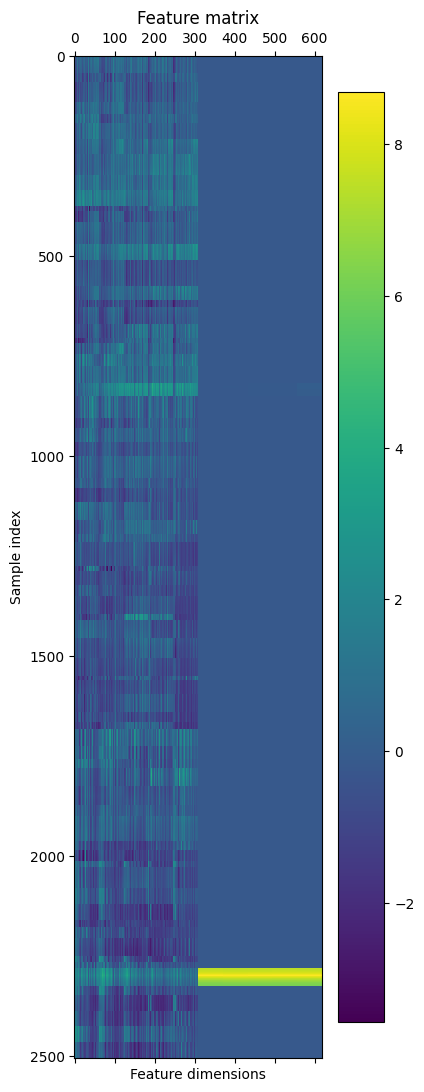

In [78]:
cp.cuda.Device(0).use()

args = get_seedIV_args()

device = get_device(args.bus_id, args.cuda_id[0])
setting_os_path(args.os_path)
# fix_random_variables(args.seed)


subject_de, subject_psd, subject_label, subject_sample_counts = load_subject_data(args.tensor_save_path, isdeap=False)


visualization_type = 1
i = 0
for p in range(1):
    if p == 0:
        n_labels_by_class = args.n_labels_by_class3
    elif p == 1:
        n_labels_by_class = args.n_labels_by_class2
    else:
        n_labels_by_class = args.n_labels_by_class1

    print("\n\n******************* SUBJECT : {} *********************".format(i+1))
    sub_idx = 'sub'+str(i+1)
    date = '230627'

    sub_de = subject_de[i]
    sub_psd = subject_psd[i]
    sub_label = subject_label[i]
    sub_sample_counts = subject_sample_counts[i]

    de, psd, identifier = other_preprocessing(sub_de,sub_psd,sub_label, n_labels_by_class, args.n_classes, args.seed)

    de = normalization(de, axis = 0, ntype='standardization')
    psd = normalization(psd, axis = 0, ntype='standardization')

    de_ssm, de_nssm = ssm_construction(de, args.n_samples, args.de_k)
    psd_ssm, psd_nssm = ssm_construction(psd, args.n_samples, args.psd_k)

    save_np(args.tensor_save_path+sub_idx, 'de_ssm_'+date, de_ssm)
    save_np(args.tensor_save_path+sub_idx, 'psd_ssm_'+date, psd_ssm)
    save_np(args.tensor_save_path+sub_idx, 'de_nssm_'+date, de_nssm)
    save_np(args.tensor_save_path+sub_idx, 'psd_nssm_'+date, psd_nssm)
    save_heatmap(de_ssm, "DE SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/DE_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
    save_heatmap(psd_ssm, "PSD SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/PSD_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
    save_heatmap(de_nssm, "DE NSSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/DE_NSSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
    save_heatmap(psd_nssm, "PSD NSSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/PSD_NSSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

    fsm = local_ssm_fusion(de_ssm,psd_ssm, de_nssm, psd_nssm, args.k1, args.t1)
    save_np(args.tensor_save_path+sub_idx, 'fused_ssm_'+date, fsm)
    save_heatmap(fsm, "Fused SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/fused_ssm/Fused_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

    adj = normalize_adj(fsm)
    save_np(args.tensor_save_path+sub_idx, 'adjacency_matrix_'+date, adj)
    save_heatmap(adj, "Normalized Adjacecy Matrix", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/adjacency_matrix/Adjacecny_Matrix_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

    feature = local_input_feature(de, psd)
    label = sub_label

    save_heatmap(feature, "Feature matrix", "Feature dimensions", "Sample index", args.figure_save_path+'heatmap/'+sub_idx+'/feature/feature_matrix_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight') 

    feature = torch.from_numpy(feature).to(torch.float32).to(device)
    adj = torch.from_numpy(adj).to(torch.float32).to(device)
    label = torch.from_numpy(label).to(torch.long).to(device)

    identifier = torch.from_numpy(identifier).bool()
    train_identifier = identifier.to(device)
    isunlabeled = ~identifier

    test_identifier = isunlabeled.to(device)

    #coo_adj = adj.to_sparse()
    #data = Data(x = feature, edge_index = coo_adj.indices(), edge_attr = coo_adj.values())
    


    activation = get_activation('celu')

In [43]:
coo_adj = adj.to_sparse()
edge_index = coo_adj.indices()

In [106]:
# Learning rate schedular will be added later
# def GTN_train(data, train_identifier, test_identifier, model, classifier,optimizer, epochs):
    
#     best_acc = 0
#     best_epoch = 0
#     best_model = None
#     best_z = None
    
#     for epoch in range(1,epochs+1):
#         model.train()

#         optimizer.zero_grad()
#         out = model(data.x, data.edge_index, data.edge_attr)
#         result = classifier(out)

#         train_pred = result[train_identifier]
#         train_y = data.y[train_identifier]
#         train_loss = criterion(train_pred, train_y)
#         train_acc = accuracy(train_pred, train_y)

#         loss.backward()
#         optimizer.step()

#         test_pred = result[test_identifier]
#         test_y = data.y[test_identifier]
#         test_loss = criterion(test_pred, test_y)
#         test_acc = accuracy(test_pred, test_y)

#         if test_acc > best_acc :
#             best_acc = test_acc
#             best_epoch = epoch
#             best_model = model
#             best_embedding = out


#         if epoch % 10 == 0:
#             print("Epoch {} - Train Acc : {}    Train Loss : {},    Test Acc : {},    Test Loss :{}".format(epoch, round(acc.item(), 2), round(loss.item(),2), round(tr_acc.item(),2), round(tr_loss.item(),2)))

#     return model, best_acc, best_epoch, best_model, best_embedding, result
def GTN_train(feature, adj,label, train_identifier, test_identifier, model, classifier,optimizer, epochs):
    
    best_acc = 0
    best_epoch = 0
    best_model = None
    best_z = None
    
    for epoch in range(1,epochs+1):
        model.train()

        optimizer.zero_grad()
        out = model(feature, adj)
        result = classifier(out)

        train_pred = result[train_identifier]
        train_y = label[train_identifier]
        train_loss = criterion(train_pred, train_y)
        train_acc = accuracy(train_pred, train_y)

        train_loss.backward()
        optimizer.step()

        test_pred = result[test_identifier]
        test_y = label[test_identifier]
        test_loss = criterion(test_pred, test_y)
        test_acc = accuracy(test_pred, test_y)

        if test_acc > best_acc :
            best_acc = test_acc
            best_epoch = epoch
            best_model = model
            best_embedding = out


        if epoch % 10 == 0:
            print("Epoch {} - Train Acc : {}    Train Loss : {},    Test Acc : {},    Test Loss :{}".format(epoch, round(train_acc.item(), 2), round(train_loss.item(),2), round(test_acc.item(),2), round(test_loss.item(),2)))

    return model, best_acc, best_epoch, best_model, best_embedding, result


In [55]:
a = torch.Tensor([[1,2,3],[4,5,6],[7,8,9]])
a.mean(-1, keepdim = True)
b = torch.rand(3,3,3)
print(b)
print(b.mean(-1,keepdim=True))

tensor([[[0.0434, 0.1213, 0.8270],
         [0.5267, 0.2581, 0.9967],
         [0.3297, 0.4165, 0.0452]],

        [[0.1673, 0.3548, 0.2039],
         [0.3691, 0.6605, 0.5169],
         [0.6743, 0.3337, 0.2286]],

        [[0.8159, 0.1234, 0.2052],
         [0.5467, 0.7836, 0.2551],
         [0.0049, 0.1152, 0.7256]]])
tensor([[[0.3306],
         [0.5938],
         [0.2638]],

        [[0.2420],
         [0.5155],
         [0.4122]],

        [[0.3815],
         [0.5285],
         [0.2819]]])


In [14]:
args.n_samples

2505

0.0

In [212]:
activation = get_activation('celu')
edge_dim = args.n_samples

hidden_graph_transformer = Encoder_GT_Layer(
                 n_samples = args.n_samples,
                 gcn_in_channels = args.feature_dimension, #Union[int, Tuple[int, int]],
                 gcn_out_channels = args.gcn_out_channels[1],
                 tfn_out_channels = args.tfn_out_channels[1],
                 ffn_proj_hid_channels = args.ffn_proj_hid_channels[1],
                 heads = args.heads[1],
                 concat = True,
                 beta = True,
                 edge_dim = args.n_samples,
                 bias = True,
                 root_weight = True,
                 dropout = args.dropout)

last_graph_transformer = Encoder_GT_Layer(
                 n_samples = args.n_samples,
                 gcn_in_channels = args.feature_dimension, #Union[int, Tuple[int, int]],
                 gcn_out_channels = args.gcn_out_channels[1],
                 tfn_out_channels = args.tfn_out_channels[1],
                 ffn_proj_hid_channels = args.ffn_proj_hid_channels[1],
                 heads = args.heads[1],
                 concat = False,
                 beta = True,
                 edge_dim = args.n_samples,
                 bias = True,
                 root_weight = True,
                 dropout = args.dropout)


model = Encoder_GT(
                 hid_layer = hidden_graph_transformer,
                 last_layer = last_graph_transformer,
                 n = args.n_gtn_layers[0]).to(device)

classifier = FC_Classifier(in_channels = args.tfn_out_channels[1],
                 hid_channels = args.fc_hid_channels,
                 out_channels = args.n_classes,
                 dropout = args.dropout).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr = args.learning_rate)

model, best_acc, best_epoch, best_model, best_embedding, result = GTN_train(feature,
                                                                            adj,
                                                                            label,
                                                                    train_identifier, 
                                                                    test_identifier,
                                                                    model, 
                                                                    classifier,
                                                                    optimizer,
                                                                            args.epochs)
# model, best_acc, best_epoch, best_model, best_embedding, result = GTN_train(data, 
#                                                                     train_identifier, 
#                                                                     test_identifier,
#                                                                     model, 
#                                                                     classifier,
#                                                                     optimizer, 
#                                                                     epochs = args.epochs)

experiment_type = 'subject_dependent'
model_save_name = sub_idx+'_model'
model_path = args.model_save_path+experiment_type+'/'+date+'/'+model_save_name
torch.save(model.state_dict(), model_path)

print("*** Best ACC : {} ***".format(round(best_acc.item(), 2)))
best_epoch_list.append(best_epoch)
best_acc_list.append(round(best_acc.item(), 2))
orig_acc_list.append(best_acc.item())


#     sample = best_z.cpu().detach().numpy().copy()
#     drmodel = TSNE(n_components = 2, perplexity = 50., n_iter_without_progress = 4000)
#     tsne_sample = StandardScaler().fit_transform(sample) # standardization
#     dr_result = drmodel.fit_transform(tsne_sample)

#     save_scatter(dr_result, label, best_acc.item(),sub_idx, date, args.figure_save_path, visualization_type, identifier)

print("\n**************** Best acc by subject *********************")
print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(best_acc_list, round(np.mean(orig_acc_list),2), round(np.std(orig_acc_list),2)))

print("\n Best Epochs : {}".format(best_epoch_list))
best_acc_list = np.array(best_acc_list)
save_np(args.tensor_save_path+sub_idx, 'protocol '+str(n_labels_by_trials*15)+'_best_acc_list_'+date, best_acc_list)

Epoch 10 - Train Acc : 100.0    Train Loss : 0.21,    Test Acc : 90.35,    Test Loss :0.42
Epoch 20 - Train Acc : 100.0    Train Loss : 0.14,    Test Acc : 92.23,    Test Loss :0.36
Epoch 30 - Train Acc : 100.0    Train Loss : 0.12,    Test Acc : 92.23,    Test Loss :0.35
Epoch 40 - Train Acc : 100.0    Train Loss : 0.11,    Test Acc : 91.74,    Test Loss :0.35
Epoch 50 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 91.74,    Test Loss :0.34
Epoch 60 - Train Acc : 100.0    Train Loss : 0.09,    Test Acc : 91.74,    Test Loss :0.34
Epoch 70 - Train Acc : 100.0    Train Loss : 0.08,    Test Acc : 91.74,    Test Loss :0.34
Epoch 80 - Train Acc : 100.0    Train Loss : 0.07,    Test Acc : 91.74,    Test Loss :0.34
Epoch 90 - Train Acc : 100.0    Train Loss : 0.06,    Test Acc : 91.74,    Test Loss :0.34
Epoch 100 - Train Acc : 100.0    Train Loss : 0.06,    Test Acc : 91.74,    Test Loss :0.34
Epoch 110 - Train Acc : 100.0    Train Loss : 0.06,    Test Acc : 91.74,    Test Loss :0.3

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [25]:
adj

tensor([[0.4781, 0.0129, 0.0129,  ..., 0.0000, 0.0000, 0.0000],
        [0.0129, 0.4782, 0.0129,  ..., 0.0000, 0.0000, 0.0000],
        [0.0129, 0.0129, 0.4782,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.5233, 0.0148, 0.0148],
        [0.0000, 0.0000, 0.0000,  ..., 0.0148, 0.5234, 0.0148],
        [0.0000, 0.0000, 0.0000,  ..., 0.0148, 0.0148, 0.5235]],
       device='cuda:2')

In [108]:
data.edge_index.shape

AttributeError: 'NoneType' object has no attribute 'shape'

# SEEDIV EEG

In [247]:
args = get_seedIV_args()
args

{'bus_id': 'PCI_BUS_ID',
 'cuda_id': ['0', '1', '2'],
 'os_path': '/home/neuroai/users/dhkim/eer/SSLGCN',
 'feature_name1': 'de_LDS',
 'feature_name2': 'psd_LDS',
 'seedIV_data_dir_path': 'dataset/seed_IV/eeg_feature_smooth/',
 'figure_save_path': 'store_seedIV/figure/',
 'tensor_save_path': 'store_seedIV/tensor/',
 'model_save_path': 'store_seedIV/model/',
 'n_classes': 4,
 'n_subjects': 15,
 'n_sessions': 3,
 'n_trials': 24,
 'n_nodes': 62,
 'n_features': 5,
 'n_samples': 2505,
 'n_labels_by_class1': 15,
 'n_labels_by_class2': 20,
 'n_labels_by_class3': 25,
 'seed': 2023,
 'EEG_band': None,
 'pca_components1': 9,
 'pca_components2': 6,
 'essm_lambda': 0.9,
 'de_k': 626,
 'psd_k': 626,
 'k1': 30,
 'k2': 130,
 't1': 1,
 't2': 1,
 'feature_dimension': 620,
 'gcn_out_channels': [64, 128],
 'tfn_out_channels': [64, 128],
 'ffn_proj_hid_channels': [256, 512],
 'fc_hid_channels': 128,
 'heads': [2, 4],
 'dropout': 0.0,
 'n_gtn_layers': [1, 2, 3, 4, 5],
 'learning_rate': 0.005,
 'weight_deca

Device: cuda
Current cuda device: 0
Count of using GPUs: 3
========================================== SEED_IV Protocol 25 ==========================================


******************* SUBJECT : 1 *********************

********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized sparse ssm construction start...
Done

directory already exists
de_ssm_230627 is saved successfully
directory already exists
psd_ssm_230627 is saved successfully
directory already exists
de_nssm_230627 is saved successfully
directory already exists
psd_nssm_230627 is saved successfully

********** Local SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step : 

tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0')
tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0')
tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0')
tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0')
Epoch 130 - Train Acc : 100.0    Train Loss : 0.05,    Test Acc : 93.68,    Test Loss :0.22
tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0')


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

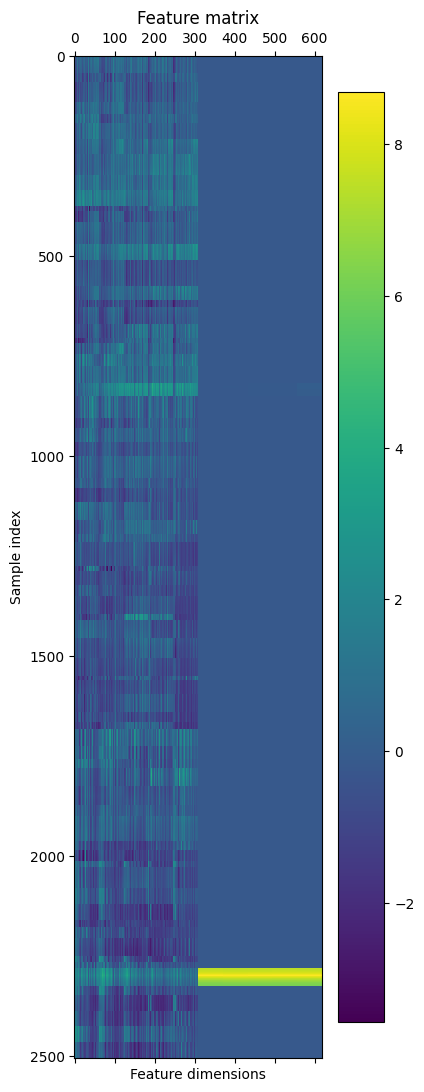

In [257]:
cp.cuda.Device(0).use()

args = get_seedIV_args()

device = get_device(args.bus_id, args.cuda_id[0])
setting_os_path(args.os_path)
# fix_random_variables(args.seed)


subject_de, subject_psd, subject_label, subject_sample_counts = load_subject_data(args.tensor_save_path, isdeap=False)


visualization_type = 1
i = 0
best_acc_protocol = []
best_std_protocol = []
for p in range(3):
    if p == 0:
        n_labels_by_class = args.n_labels_by_class3
    elif p == 1:
        n_labels_by_class = args.n_labels_by_class2
    else:
        n_labels_by_class = args.n_labels_by_class1
        
    best_epoch_list = []
    best_acc_list = []
    orig_acc_list = []


    print("========================================== SEED_IV Protocol {} ==========================================".format(int(n_labels_by_class)))

    for i in range(args.n_subjects):
        print("\n\n******************* SUBJECT : {} *********************".format(i+1))
        sub_idx = 'sub'+str(i+1)
        date = '230627'

        sub_de = subject_de[i]
        sub_psd = subject_psd[i]
        sub_label = subject_label[i]
        sub_sample_counts = subject_sample_counts[i]

        de, psd, identifier = other_preprocessing(sub_de,sub_psd,sub_label, n_labels_by_class, args.n_classes, args.seed)

        de = normalization(de, axis = 0, ntype='standardization')
        psd = normalization(psd, axis = 0, ntype='standardization')

        de_ssm, de_nssm = ssm_construction(de, args.n_samples, args.de_k)
        psd_ssm, psd_nssm = ssm_construction(psd, args.n_samples, args.psd_k)

        save_np(args.tensor_save_path+sub_idx, 'de_ssm_'+date, de_ssm)
        save_np(args.tensor_save_path+sub_idx, 'psd_ssm_'+date, psd_ssm)
        save_np(args.tensor_save_path+sub_idx, 'de_nssm_'+date, de_nssm)
        save_np(args.tensor_save_path+sub_idx, 'psd_nssm_'+date, psd_nssm)
        save_heatmap(de_ssm, "DE SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/DE_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
        save_heatmap(psd_ssm, "PSD SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/PSD_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
        save_heatmap(de_nssm, "DE NSSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/DE_NSSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
        save_heatmap(psd_nssm, "PSD NSSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/PSD_NSSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

        fsm = local_ssm_fusion(de_ssm,psd_ssm, de_nssm, psd_nssm, args.k1, args.t1)
        save_np(args.tensor_save_path+sub_idx, 'fused_ssm_'+date, fsm)
        save_heatmap(fsm, "Fused SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/fused_ssm/Fused_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

        adj = normalize_adj(fsm)
        save_np(args.tensor_save_path+sub_idx, 'adjacency_matrix_'+date, adj)
        save_heatmap(adj, "Normalized Adjacecy Matrix", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/adjacency_matrix/Adjacecny_Matrix_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

        feature = local_input_feature(de, psd)
        label = sub_label

        save_heatmap(feature, "Feature matrix", "Feature dimensions", "Sample index", args.figure_save_path+'heatmap/'+sub_idx+'/feature/feature_matrix_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight') 

        feature = torch.from_numpy(feature).to(torch.float32).to(device)
        adj = torch.from_numpy(adj).to(torch.float32).to(device)
        label = torch.from_numpy(label).to(torch.long).to(device)

        identifier = torch.from_numpy(identifier).bool()
        train_identifier = identifier.to(device)
        isunlabeled = ~identifier

        test_identifier = isunlabeled.to(device)

        #coo_adj = adj.to_sparse()
        #data = Data(x = feature, edge_index = coo_adj.indices(), edge_attr = coo_adj.values())
    


        activation = get_activation('celu')
        edge_dim = args.n_samples

        hidden_graph_transformer = Encoder_GT_Layer(
                         n_samples = args.n_samples,
                         gcn_in_channels = args.feature_dimension, #Union[int, Tuple[int, int]],
                         gcn_out_channels = args.gcn_out_channels[1],
                         tfn_out_channels = args.tfn_out_channels[1],
                         ffn_proj_hid_channels = args.ffn_proj_hid_channels[1],
                         heads = args.heads[1],
                         concat = True,
                         beta = True,
                         edge_dim = args.n_samples,
                         bias = True,
                         root_weight = True,
                         dropout = args.dropout)

        last_graph_transformer = Encoder_GT_Layer(
                         n_samples = args.n_samples,
                         gcn_in_channels = args.feature_dimension, #Union[int, Tuple[int, int]],
                         gcn_out_channels = args.gcn_out_channels[1],
                         tfn_out_channels = args.tfn_out_channels[1],
                         ffn_proj_hid_channels = args.ffn_proj_hid_channels[1],
                         heads = args.heads[1],
                         concat = False,
                         beta = True,
                         edge_dim = args.n_samples,
                         bias = True,
                         root_weight = True,
                         dropout = args.dropout)


        model = Encoder_GT(
                         hid_layer = hidden_graph_transformer,
                         last_layer = last_graph_transformer,
                         n = args.n_gtn_layers[0]).to(device)

        classifier = FC_Classifier(in_channels = args.tfn_out_channels[1],
                         hid_channels = args.fc_hid_channels,
                         out_channels = args.n_classes,
                         dropout = args.dropout).to(device)


        optimizer = torch.optim.Adam(model.parameters(), lr = args.learning_rate)

        model, best_acc, best_epoch, best_model, best_embedding, result = GTN_train(feature,
                                                                                    adj,
                                                                                    label,
                                                                            train_identifier, 
                                                                            test_identifier,
                                                                            model, 
                                                                            classifier,
                                                                            optimizer,
                                                                                    args.epochs)
        # model, best_acc, best_epoch, best_model, best_embedding, result = GTN_train(data, 
        #                                                                     train_identifier, 
        #                                                                     test_identifier,
        #                                                                     model, 
        #                                                                     classifier,
        #                                                                     optimizer, 
        #                                                                     epochs = args.epochs)

        experiment_type = 'subject_dependent'
        model_save_name = sub_idx+'_model'
        model_path = args.model_save_path+experiment_type+'/'+date+'/'+model_save_name
        torch.save(model.state_dict(), model_path)

        print("*** Best ACC : {} ***".format(round(best_acc.item(), 2)))
        best_epoch_list.append(best_epoch)
        best_acc_list.append(round(best_acc.item(), 2))
        orig_acc_list.append(best_acc.item())


        #     sample = best_z.cpu().detach().numpy().copy()
        #     drmodel = TSNE(n_components = 2, perplexity = 50., n_iter_without_progress = 4000)
        #     tsne_sample = StandardScaler().fit_transform(sample) # standardization
        #     dr_result = drmodel.fit_transform(tsne_sample)

        #     save_scatter(dr_result, label, best_acc.item(),sub_idx, date, args.figure_save_path, visualization_type, identifier)

    print("\n**************** Best acc by subject *********************")
    print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(best_acc_list, round(np.mean(orig_acc_list),2), round(np.std(orig_acc_list),2)))

    print("\n Best Epochs : {}".format(best_epoch_list))
    best_acc_list = np.array(best_acc_list)
    save_np(args.tensor_save_path+sub_idx, 'protocol '+str(n_labels_by_trials*15)+'_best_acc_list_'+date, best_acc_list)
    best_acc_protocol.append(best_acc_list.mean())
    best_std_protocol.append(best_acc_list.std())

print("***********************************************")
print("best_acc by protocol: ", best_acc_protocol)
print("best_std by protocol: ", best_std_protocol)
    

In [260]:
hidden_graph_transformer = Encoder_GT_Layer(
                 n_samples = args.n_samples,
                 gcn_in_channels = args.feature_dimension, #Union[int, Tuple[int, int]],
                 gcn_out_channels = args.gcn_out_channels[1],
                 tfn_out_channels = args.tfn_out_channels[1],
                 ffn_proj_hid_channels = args.ffn_proj_hid_channels[1],
                 heads = args.heads[1],
                 concat = True,
                 beta = True,
                 edge_dim = args.n_samples,
                 bias = True,
                 root_weight = True,
                 dropout = args.dropout)

last_graph_transformer = Encoder_GT_Layer(
                 n_samples = args.n_samples,
                 gcn_in_channels = args.feature_dimension, #Union[int, Tuple[int, int]],
                 gcn_out_channels = args.gcn_out_channels[1],
                 tfn_out_channels = args.tfn_out_channels[1],
                 ffn_proj_hid_channels = args.ffn_proj_hid_channels[1],
                 heads = args.heads[1],
                 concat = False,
                 beta = True,
                 edge_dim = args.n_samples,
                 bias = True,
                 root_weight = True,
                 dropout = args.dropout)


model = Encoder_GT(
                 hid_layer = hidden_graph_transformer,
                 last_layer = last_graph_transformer,
                 n = args.n_gtn_layers[0]).to(device)

classifier = FC_Classifier(in_channels = args.tfn_out_channels[1],
                 hid_channels = args.fc_hid_channels,
                 out_channels = args.n_classes,
                 dropout = args.dropout).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr = args.learning_rate)

model, best_acc, best_epoch, best_model, best_embedding, result = GTN_train(feature,
                                                                            adj,
                                                                            label,
                                                                    train_identifier, 
                                                                    test_identifier,
                                                                    model, 
                                                                    classifier,
                                                                    optimizer,
                                                                            args.epochs)
# model, best_acc, best_epoch, best_model, best_embedding, result = GTN_train(data, 
#                                                                     train_identifier, 
#                                                                     test_identifier,
#                                                                     model, 
#                                                                     classifier,
#                                                                     optimizer, 
#                                                                     epochs = args.epochs)


(tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0'), tensor([   0,    0,    0,  ..., 2504, 2504, 2504], device='cuda:0'), tensor([ 376,  377,  378,  ..., 2502, 2503, 2504], device='cuda:0'))
(tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0'), tensor([   0,    0,    0,  ..., 2504, 2504, 2504], device='cuda:0'), tensor([  65,   66,   67,  ..., 2502, 2503, 2504], device='cuda:0'))
(tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0'), tensor([   0,    0,    0,  ..., 2504, 2504, 2504], device='cuda:0'), tensor([   0,    1,    2,  ..., 2502, 2503, 2504], device='cuda:0'))
(tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0'), tensor([   0,    0,    0,  ..., 2504, 2504, 2504], device='cuda:0'), tensor([   0,    1,    2,  ..., 2463, 2464, 2465], device='cuda:0'))
(tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0'), tensor([   0,    0,    0,  ..., 2504, 2504, 2504], device='cuda:0'), tensor([   0,    1,    2,  ..., 2463, 2464, 2465], device='cuda:0'))
(tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0')

(tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0'), tensor([   0,    0,    0,  ..., 2504, 2504, 2504], device='cuda:0'), tensor([   0,    1,    2,  ..., 2463, 2464, 2465], device='cuda:0'))
(tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0'), tensor([   0,    0,    0,  ..., 2504, 2504, 2504], device='cuda:0'), tensor([   0,    1,    2,  ..., 2463, 2464, 2465], device='cuda:0'))
(tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0'), tensor([   0,    0,    0,  ..., 2504, 2504, 2504], device='cuda:0'), tensor([   0,    1,    2,  ..., 2463, 2464, 2465], device='cuda:0'))
(tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0'), tensor([   0,    0,    0,  ..., 2504, 2504, 2504], device='cuda:0'), tensor([   0,    1,    2,  ..., 2463, 2464, 2465], device='cuda:0'))
(tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0'), tensor([   0,    0,    0,  ..., 2504, 2504, 2504], device='cuda:0'), tensor([   0,    1,    2,  ..., 2463, 2464, 2465], device='cuda:0'))
Epoch 50 - Train Acc : 100.0    Train Loss : 0.1, 

(tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0'), tensor([   0,    0,    0,  ..., 2504, 2504, 2504], device='cuda:0'), tensor([   0,    1,    2,  ..., 2463, 2464, 2465], device='cuda:0'))
(tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0'), tensor([   0,    0,    0,  ..., 2504, 2504, 2504], device='cuda:0'), tensor([   0,    1,    2,  ..., 2463, 2464, 2465], device='cuda:0'))
(tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0'), tensor([   0,    0,    0,  ..., 2504, 2504, 2504], device='cuda:0'), tensor([   0,    1,    2,  ..., 2463, 2464, 2465], device='cuda:0'))
(tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0'), tensor([   0,    0,    0,  ..., 2504, 2504, 2504], device='cuda:0'), tensor([   0,    1,    2,  ..., 2463, 2464, 2465], device='cuda:0'))
Epoch 100 - Train Acc : 100.0    Train Loss : 0.06,    Test Acc : 93.68,    Test Loss :0.22
(tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0'), tensor([   0,    0,    0,  ..., 2504, 2504, 2504], device='cuda:0'), tensor([   0,    1,    2,  

(tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0'), tensor([   0,    0,    0,  ..., 2504, 2504, 2504], device='cuda:0'), tensor([   0,    1,    2,  ..., 2463, 2464, 2465], device='cuda:0'))
(tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0'), tensor([   0,    0,    0,  ..., 2504, 2504, 2504], device='cuda:0'), tensor([   0,    1,    2,  ..., 2463, 2464, 2465], device='cuda:0'))
(tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0'), tensor([   0,    0,    0,  ..., 2504, 2504, 2504], device='cuda:0'), tensor([   0,    1,    2,  ..., 2463, 2464, 2465], device='cuda:0'))
(tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0'), tensor([   0,    0,    0,  ..., 2504, 2504, 2504], device='cuda:0'), tensor([   0,    1,    2,  ..., 2463, 2464, 2465], device='cuda:0'))
Epoch 150 - Train Acc : 100.0    Train Loss : 0.04,    Test Acc : 93.68,    Test Loss :0.22
(tensor([0, 0, 0,  ..., 3, 3, 3], device='cuda:0'), tensor([   0,    0,    0,  ..., 2504, 2504, 2504], device='cuda:0'), tensor([   0,    1,    2,  

KeyboardInterrupt: 

In [220]:
hidden_graph_transformer = Encoder_GT_Layer(
                         n_samples = args.n_samples,
                         gcn_in_channels = args.feature_dimension, #Union[int, Tuple[int, int]],
                         gcn_out_channels = args.gcn_out_channels[1],
                         tfn_out_channels = args.tfn_out_channels[1],
                         ffn_proj_hid_channels = args.ffn_proj_hid_channels[1],
                         heads = args.heads[1],
                         concat = True,
                         beta = True,
                         edge_dim = args.n_samples,
                         bias = True,
                         root_weight = True,
                         dropout = args.dropout)

last_graph_transformer = Encoder_GT_Layer(
                 n_samples = args.n_samples,
                 gcn_in_channels = args.feature_dimension, #Union[int, Tuple[int, int]],
                 gcn_out_channels = args.gcn_out_channels[1],
                 tfn_out_channels = args.tfn_out_channels[1],
                 ffn_proj_hid_channels = args.ffn_proj_hid_channels[1],
                 heads = args.heads[1],
                 concat = False,
                 beta = True,
                 edge_dim = args.n_samples,
                 bias = True,
                 root_weight = True,
                 dropout = args.dropout)


model = Encoder_GT(
                 hid_layer = hidden_graph_transformer,
                 last_layer = last_graph_transformer,
                 n = args.n_gtn_layers[0]).to(device)

classifier = FC_Classifier(in_channels = args.tfn_out_channels[1],
                 hid_channels = args.fc_hid_channels,
                 out_channels = args.n_classes,
                 dropout = args.dropout).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr = args.learning_rate)

model, best_acc, best_epoch, best_model, best_embedding, result = GTN_train(feature,
                                                                            adj,
                                                                            label,
                                                                    train_identifier, 
                                                                    test_identifier,
                                                                    model, 
                                                                    classifier,
                                                                    optimizer,
                                                                            args.epochs)

tensor([[ 0.0792, -0.1909, -0.0674,  ...,  0.8130,  0.2018,  0.1181],
        [ 0.0793, -0.1907, -0.0677,  ...,  0.8132,  0.2014,  0.1183],
        [ 0.0797, -0.1906, -0.0677,  ...,  0.8130,  0.2009,  0.1183],
        ...,
        [-0.1902,  0.1132, -0.1438,  ...,  0.0429,  0.3258,  0.0229],
        [-0.1904,  0.1133, -0.1438,  ...,  0.0429,  0.3255,  0.0230],
        [-0.1904,  0.1135, -0.1438,  ...,  0.0430,  0.3253,  0.0231]],
       device='cuda:0', grad_fn=<CeluBackward0>)
tensor([[ 0.0792, -0.0909, -0.0674,  ...,  0.9130,  0.2018,  0.2181],
        [ 0.1635, -0.1367,  0.0085,  ...,  0.9132,  0.2014,  0.2183],
        [ 0.1707, -0.2322,  0.0310,  ...,  0.9130,  0.2009,  0.2183],
        ...,
        [-0.0940,  0.1407, -0.2308,  ...,  0.1373,  0.3543,  0.1187],
        [-0.1153,  0.0473, -0.1627,  ...,  0.1373,  0.3540,  0.1188],
        [-0.2054,  0.0146, -0.0812,  ...,  0.1374,  0.3538,  0.1189]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor([[ 0.3128, -0.2926,  2.1922,

tensor([[ 3.1180, -0.8442,  3.2539,  ..., -0.6871, -0.8984, -0.9862],
        [ 3.1180, -0.8442,  3.2549,  ..., -0.6877, -0.8986, -0.9862],
        [ 3.1152, -0.8442,  3.2550,  ..., -0.6882, -0.8987, -0.9862],
        ...,
        [-0.4693,  7.2843, -0.9498,  ..., -0.9793, -0.8178, -0.9821],
        [-0.4685,  7.2849, -0.9498,  ..., -0.9793, -0.8178, -0.9821],
        [-0.4680,  7.2814, -0.9497,  ..., -0.9793, -0.8175, -0.9821]],
       device='cuda:0', grad_fn=<CeluBackward0>)
tensor([[ 3.1180, -0.7442,  3.2539,  ..., -0.5871, -0.8984, -0.8862],
        [ 3.2022, -0.7902,  3.3311,  ..., -0.5877, -0.8985, -0.8862],
        [ 3.2061, -0.8858,  3.3537,  ..., -0.5882, -0.8987, -0.8862],
        ...,
        [-0.3732,  7.3118, -1.0369,  ..., -0.8848, -0.7893, -0.8862],
        [-0.3934,  7.2189, -0.9687,  ..., -0.8848, -0.7893, -0.8863],
        [-0.4831,  7.1825, -0.8872,  ..., -0.8848, -0.7890, -0.8863]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor([[ 3.4670, -0.9017,  3.3909,

tensor([[ 7.6667, -0.9999,  4.0968,  ..., -0.9994, -0.9984, -0.9972],
        [ 7.6668, -0.9999,  4.0987,  ..., -0.9994, -0.9984, -0.9972],
        [ 7.6647, -0.9999,  4.1015,  ..., -0.9994, -0.9984, -0.9972],
        ...,
        [-0.9891, 10.5554, -0.9723,  ..., -0.9994, -0.9820, -0.9999],
        [-0.9891, 10.5522, -0.9722,  ..., -0.9994, -0.9819, -0.9999],
        [-0.9890, 10.5460, -0.9721,  ..., -0.9994, -0.9819, -0.9999]],
       device='cuda:0', grad_fn=<CeluBackward0>)
tensor([[ 7.6667, -0.8999,  4.0968,  ..., -0.8994, -0.9984, -0.8972],
        [ 7.7509, -0.9459,  4.1749,  ..., -0.8994, -0.9983, -0.8972],
        [ 7.7556, -1.0416,  4.2002,  ..., -0.8994, -0.9983, -0.8972],
        ...,
        [-0.8929, 10.5829, -1.0594,  ..., -0.9049, -0.9535, -0.9041],
        [-0.9140, 10.4862, -0.9912,  ..., -0.9049, -0.9534, -0.9041],
        [-1.0040, 10.4471, -0.9096,  ..., -0.9049, -0.9534, -0.9041]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor([[ 7.6814, -0.9999,  4.1158,

tensor([[ 7.6691, -1.0000,  4.6712,  ..., -0.9995, -0.9984, -0.9993],
        [ 7.6692, -1.0000,  4.6751,  ..., -0.9995, -0.9984, -0.9993],
        [ 7.6671, -1.0000,  4.6758,  ..., -0.9995, -0.9984, -0.9993],
        ...,
        [-0.9983, 11.5333, -0.9771,  ..., -0.9998, -0.9853, -1.0000],
        [-0.9983, 11.5302, -0.9769,  ..., -0.9998, -0.9854, -1.0000],
        [-0.9983, 11.5237, -0.9769,  ..., -0.9998, -0.9853, -1.0000]],
       device='cuda:0', grad_fn=<CeluBackward0>)
tensor([[ 7.6691, -0.9000,  4.6712,  ..., -0.8995, -0.9984, -0.8993],
        [ 7.7533, -0.9459,  4.7513,  ..., -0.8995, -0.9983, -0.8993],
        [ 7.7580, -1.0416,  4.7745,  ..., -0.8995, -0.9983, -0.8993],
        ...,
        [-0.9022, 11.5608, -1.0641,  ..., -0.9053, -0.9569, -0.9041],
        [-0.9232, 11.4641, -0.9959,  ..., -0.9053, -0.9568, -0.9041],
        [-1.0133, 11.4248, -0.9143,  ..., -0.9053, -0.9568, -0.9041]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor([[ 7.6692, -1.0000,  4.6988,

tensor([[ 7.7792, -1.0000,  5.0581,  ..., -0.9994, -0.9982, -0.9996],
        [ 7.7792, -1.0000,  5.0600,  ..., -0.9994, -0.9982, -0.9996],
        [ 7.7771, -1.0000,  5.0606,  ..., -0.9994, -0.9982, -0.9996],
        ...,
        [-0.9977, 12.2499, -0.9775,  ..., -0.9998, -0.9824, -1.0000],
        [-0.9977, 12.2468, -0.9774,  ..., -0.9998, -0.9824, -1.0000],
        [-0.9977, 12.2402, -0.9773,  ..., -0.9998, -0.9824, -1.0000]],
       device='cuda:0', grad_fn=<CeluBackward0>)
tensor([[ 7.7792, -0.9000,  5.0581,  ..., -0.8994, -0.9982, -0.8996],
        [ 7.8634, -0.9459,  5.1362,  ..., -0.8994, -0.9982, -0.8996],
        [ 7.8680, -1.0416,  5.1593,  ..., -0.8994, -0.9982, -0.8996],
        ...,
        [-0.9015, 12.2774, -1.0645,  ..., -0.9053, -0.9539, -0.9041],
        [-0.9226, 12.1807, -0.9963,  ..., -0.9053, -0.9539, -0.9041],
        [-1.0127, 12.1413, -0.9148,  ..., -0.9053, -0.9539, -0.9041]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor([[ 7.7802, -1.0000,  5.0706,

tensor([[ 7.6922, -1.0000,  5.3409,  ..., -0.9993, -0.9981, -0.9996],
        [ 7.6923, -1.0000,  5.3448,  ..., -0.9993, -0.9981, -0.9996],
        [ 7.6902, -1.0000,  5.3453,  ..., -0.9993, -0.9981, -0.9996],
        ...,
        [-0.9960, 12.4756, -0.9780,  ..., -0.9998, -0.9804, -1.0000],
        [-0.9960, 12.4726, -0.9779,  ..., -0.9998, -0.9804, -1.0000],
        [-0.9960, 12.4659, -0.9778,  ..., -0.9998, -0.9803, -1.0000]],
       device='cuda:0', grad_fn=<CeluBackward0>)
tensor([[ 7.6922, -0.9000,  5.3409,  ..., -0.8993, -0.9981, -0.8996],
        [ 7.7764, -0.9459,  5.4209,  ..., -0.8993, -0.9981, -0.8996],
        [ 7.7811, -1.0416,  5.4440,  ..., -0.8993, -0.9981, -0.8996],
        ...,
        [-0.8999, 12.5031, -1.0650,  ..., -0.9053, -0.9519, -0.9041],
        [-0.9209, 12.4065, -0.9968,  ..., -0.9053, -0.9519, -0.9041],
        [-1.0110, 12.3670, -0.9152,  ..., -0.9053, -0.9518, -0.9041]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor([[ 7.6919, -1.0000,  5.3564,

KeyboardInterrupt: 

In [156]:
np.array(best_acc_list).std()

3.517228454337306

# SEED (120, 90, 60)

In [ ]:
cp.cuda.Device(0).use()

args = get_seed_args()

device = get_device(args.bus_id, args.cuda_id[0])
setting_os_path(args.os_path)
# fix_random_variables(args.seed)


subject_de, subject_psd, subject_label, subject_sample_counts = load_subject_data(args.tensor_save_path, isdeap=False)


visualization_type = 1

for p in range(1):
    if p == 0:
        n_labels_by_trials = args.n_labels_by_trials3
    elif p == 1:
        n_labels_by_trials = args.n_labels_by_trials2
    else:
        n_labels_by_trials = args.n_labels_by_trials1
        
    best_epoch_list = []
    best_acc_list = []
    orig_acc_list = []
    print("========================================== SEED Protocol {} ==========================================".format(int(n_labels_by_trials*15)))

    for i in range(15):
        print("\n\n******************* SUBJECT : {} *********************".format(i+1))
        sub_idx = 'sub'+str(i+1)
        date = '230405'

        sub_de = subject_de[i]
        sub_psd = subject_psd[i]
        sub_label = subject_label[i]
        sub_sample_counts = subject_sample_counts[i]

        de,identifier = preprocessing(sub_de, sub_sample_counts, args.n_samples, n_labels_by_trials, args.n_nodes, args.n_features, args.seed)
        psd,_ = preprocessing(sub_psd, sub_sample_counts, args.n_samples, n_labels_by_trials, args.n_nodes, args.n_features, args.seed)

        de = normalization(de, axis = 0, ntype='standardization')
        psd = normalization(psd, axis = 0, ntype='standardization')

        de_ssm, de_nssm = ssm_construction(de, args.n_samples, args.de_k)
        psd_ssm, psd_nssm = ssm_construction(psd, args.n_samples, args.psd_k)

        save_np(args.tensor_save_path+sub_idx, 'de_ssm_'+date, de_ssm)
        save_np(args.tensor_save_path+sub_idx, 'psd_ssm_'+date, psd_ssm)
        save_np(args.tensor_save_path+sub_idx, 'de_nssm_'+date, de_nssm)
        save_np(args.tensor_save_path+sub_idx, 'psd_nssm_'+date, psd_nssm)
        save_heatmap(de_ssm, "DE SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/DE_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
        save_heatmap(psd_ssm, "PSD SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/PSD_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
        save_heatmap(de_nssm, "DE NSSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/DE_NSSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
        save_heatmap(psd_nssm, "PSD NSSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/PSD_NSSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

        fsm = ssm_fusion(de_ssm,psd_ssm, de_nssm, psd_nssm, args.k1, args.t1)
        save_np(args.tensor_save_path+sub_idx, 'fused_ssm_'+date, fsm)
        save_heatmap(fsm, "Fused SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/fused_ssm/Fused_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

        adj = normalize_adj(fsm)
        save_np(args.tensor_save_path+sub_idx, 'adjacency_matrix_'+date, adj)
        save_heatmap(adj, "Normalized Adjacecy Matrix", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/adjacency_matrix/Adjacecny_Matrix_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

        feature = input_feature(de, psd)
        label = sub_label

        save_heatmap(feature, "Feature matrix", "Feature dimensions", "Sample index", args.figure_save_path+'heatmap/'+sub_idx+'/feature/feature_matrix_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight') 

        feature = torch.from_numpy(feature).to(torch.float32).to(device)
        adj = torch.from_numpy(adj).to(torch.float32).to(device)
        label = torch.from_numpy(label).to(torch.long).to(device)

        identifier = torch.from_numpy(identifier).bool()
        train_identifier = identifier.to(device)
        isunlabeled = ~identifier

        test_identifier = isunlabeled.to(device)

        activation = get_activation('celu')
        gcn = GraphConvolution

        encoder = Encoder(args.feature_dimension, args.gcn_hid_channels, args.gcn_out_channels, activation, args.seed, base_model = gcn).to(device)
        model = GRACE(encoder, args.feature_dimension, args.gcn_out_channels, args.proj_hid_channels, args.out_channels, args.ptau).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr = args.learning_rate)

        model, best_acc, best_epoch, best_model, best_z, result = GCA_train(model, optimizer, feature, adj, label,
                                                                            train_identifier, test_identifier,
                                                                            args,device,date,sub_idx, isdeap=False)

        experiment_type = 'subject_dependent'
        model_save_name = sub_idx+'_model'
        model_path = args.model_save_path+experiment_type+'/'+date+'/'+model_save_name
        torch.save(model.state_dict(), model_path)
    
        print("*** Best ACC : {} ***".format(round(best_acc.item(), 2)))
        best_epoch_list.append(best_epoch)
        best_acc_list.append(round(best_acc.item(), 2))
        orig_acc_list.append(best_acc.item())


    #     sample = best_z.cpu().detach().numpy().copy()
    #     drmodel = TSNE(n_components = 2, perplexity = 50., n_iter_without_progress = 4000)
    #     tsne_sample = StandardScaler().fit_transform(sample) # standardization
    #     dr_result = drmodel.fit_transform(tsne_sample)

    #     save_scatter(dr_result, label, best_acc.item(),sub_idx, date, args.figure_save_path, visualization_type, identifier)

    print("\n**************** Best acc by subject *********************")
    print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(best_acc_list, round(np.mean(orig_acc_list),2), round(np.std(orig_acc_list),2)))

    print("\n Best Epochs : {}".format(best_epoch_list))
    best_acc_list = np.array(best_acc_list)
    save_np(args.tensor_save_path+sub_idx, 'protocol '+str(n_labels_by_trials*15)+'_best_acc_list_'+date, best_acc_list)